### Курсовой проект для курса "Python для Data Science"

In [1]:
import numpy as np
import pandas as pd
import random

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score as r2
from sklearn.model_selection import KFold, GridSearchCV

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
matplotlib.rcParams.update({'font.size': 14})

**Пути к директориям и файлам**

In [4]:
#DATASET_PATH = 'train.csv'
PREPARED_DATASET_PATH = 'train_prepared.csv'
TRAIN_DATASET_PATH = 'train.csv'
TEST_DATASET_PATH = 'test.csv'

**Задание:**

Используя данные из обучающего датасета (train.csv), построить модель для предсказания цен на недвижимость (квартиры).
С помощью полученной модели, предсказать цены для квартир из тестового датасета (test.csv).

Целевая переменная:
Price

**Метрика качества:**
R2 - коэффициент детерминации (sklearn.metrics.r2_score)

**Требования к решению:**
1. R2 > 0.6
2. Тетрадка Jupyter Notebook с кодом Вашего решения, названная по образцу {ФИО}_solution.ipynb, пример SShirkin_solution.ipynb
3. Файл CSV с прогнозами целевой переменной для тестового датасета, названный по образцу {ФИО}_predictions.csv, пример SShirkin_predictions.csv 
Файл должен содержать два поля: Id, Price и в файле должна быть 5001 строка (шапка + 5000 предсказаний).

**Рекомендации для файла с кодом (ipynb):**
1. Файл должен содержать заголовки и комментарии (markdown)
2. Повторяющиеся операции лучше оформлять в виде функций
3. Не делать вывод большого количества строк таблиц (5-10 достаточно)
4. По возможности добавлять графики, описывающие данные (около 3-5)
5. Добавлять только лучшую модель, то есть не включать в код все варианты решения проекта
6. Скрипт проекта должен отрабатывать от начала и до конца (от загрузки данных до выгрузки предсказаний)
7. Весь проект должен быть в одном скрипте (файл ipynb).
8. Допускается применение библиотек Python и моделей машинного обучения,
которые были в данном курсе.

### Загрузка данных

**Описание датасета**

* **Id** - идентификационный номер квартиры
* **DistrictId** - идентификационный номер района
* **Rooms** - количество комнат
* **Square** - площадь
* **LifeSquare** - жилая площадь
* **KitchenSquare** - площадь кухни
* **Floor** - этаж
* **HouseFloor** - количество этажей в доме
* **HouseYear** - год постройки дома
* **Ecology_1, Ecology_2, Ecology_3** - экологические показатели местности
* **Social_1, Social_2, Social_3** - социальные показатели местности
* **Healthcare_1, Helthcare_2** - показатели местности, связанные с охраной здоровья
* **Shops_1, Shops_2** - показатели, связанные с наличием магазинов, торговых центров
* **Price** - цена квартиры


In [5]:
train_df = pd.read_csv(TRAIN_DATASET_PATH)
train_df.tail(n=3)

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
9997,5123,27,1.0,47.939008,NaN,1.0,12,16.0,2015,0.072158,B,B,2,629,1,NaN,0,0,A,159143.805370
9998,5400,75,2.0,43.602562,33.840147,8.0,1,5.0,1961,0.307467,B,A,30,5048,9,325.0,2,5,B,181595.339808
9999,6306,128,1.0,38.666645,21.157874,8.0,7,17.0,1990,0.000000,B,B,27,4798,0,30.0,2,8,B,218714.077615


In [6]:
train_df.shape

(10000, 20)

In [7]:
test_df = pd.read_csv(TEST_DATASET_PATH)
test_df.tail(n=3)

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2
4997,5783,12,3.0,77.842178,48.282625,9.0,23,22.0,1989,0.090799,B,B,74,19083,2,NaN,5,15,B
4998,4780,62,2.0,81.305222,NaN,0.0,4,0.0,1977,0.072158,B,B,2,629,1,NaN,0,0,A
4999,12504,30,2.0,60.555693,NaN,1.0,10,17.0,1977,0.000078,B,B,22,6398,141,1046.0,3,23,B


In [8]:
test_df.shape

(5000, 19)

In [9]:
train_df.shape[1]-1 == test_df.shape[1]

True

In [10]:
data = pd.concat([train_df, test_df], axis=0)
data = data.reset_index(drop=True)
data.shape

(15000, 20)

In [11]:
x_train = data[data["Price"].notnull()]
x_test = data[data["Price"].isnull()]

In [12]:
data.head(10)

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
0,14038,35,2.0,47.981561,29.442751,6.0,7,9.0,1969,0.089040,B,B,33,7976,5,NaN,0,11,B,184966.930730
1,15053,41,3.0,65.683640,40.049543,8.0,7,9.0,1978,0.000070,B,B,46,10309,1,240.0,1,16,B,300009.450063
2,4765,53,2.0,44.947953,29.197612,0.0,8,12.0,1968,0.049637,B,B,34,7759,0,229.0,1,3,B,220925.908524
3,5809,58,2.0,53.352981,52.731512,9.0,8,17.0,1977,0.437885,B,B,23,5735,3,1084.0,0,5,B,175616.227217
4,10783,99,1.0,39.649192,23.776169,7.0,11,12.0,1976,0.012339,B,B,35,5776,1,2078.0,2,4,B,150226.531644
5,12915,59,3.0,80.384479,46.683720,12.0,5,17.0,2011,0.309479,B,B,35,7715,4,990.0,0,6,B,215898.447742
6,14549,154,2.0,62.254114,37.160377,7.0,3,5.0,1960,0.460556,B,B,20,4386,14,NaN,1,5,B,296021.204377
7,11993,74,2.0,80.312926,NaN,0.0,14,0.0,1977,0.075779,B,B,6,1437,3,NaN,0,2,B,221244.156664
8,5172,1,2.0,64.511437,NaN,1.0,9,17.0,1977,0.007122,B,B,1,264,0,NaN,0,1,B,229102.795999
9,8649,23,1.0,46.461409,18.915552,8.0,13,17.0,2014,0.075779,B,B,6,1437,3,NaN,0,2,B,95380.220993


In [13]:
data.tail(n=2)

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
14998,4780,62,2.0,81.305222,NaN,0.0,4,0.0,1977,0.072158,B,B,2,629,1,NaN,0,0,A,NaN
14999,12504,30,2.0,60.555693,NaN,1.0,10,17.0,1977,0.000078,B,B,22,6398,141,1046.0,3,23,B,NaN


### Приведение типов данных

In [14]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15000 entries, 0 to 14999
Data columns (total 20 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             15000 non-null  int64  
 1   DistrictId     15000 non-null  int64  
 2   Rooms          15000 non-null  float64
 3   Square         15000 non-null  float64
 4   LifeSquare     11846 non-null  float64
 5   KitchenSquare  15000 non-null  float64
 6   Floor          15000 non-null  int64  
 7   HouseFloor     15000 non-null  float64
 8   HouseYear      15000 non-null  int64  
 9   Ecology_1      15000 non-null  float64
 10  Ecology_2      15000 non-null  object 
 11  Ecology_3      15000 non-null  object 
 12  Social_1       15000 non-null  int64  
 13  Social_2       15000 non-null  int64  
 14  Social_3       15000 non-null  int64  
 15  Healthcare_1   7825 non-null   float64
 16  Helthcare_2    15000 non-null  int64  
 17  Shops_1        15000 non-null  int64  
 18  Shops_

In [15]:
data.dtypes

Id                 int64
DistrictId         int64
Rooms            float64
Square           float64
LifeSquare       float64
KitchenSquare    float64
Floor              int64
HouseFloor       float64
HouseYear          int64
Ecology_1        float64
Ecology_2         object
Ecology_3         object
Social_1           int64
Social_2           int64
Social_3           int64
Healthcare_1     float64
Helthcare_2        int64
Shops_1            int64
Shops_2           object
Price            float64
dtype: object

In [16]:
data['Id'] = data['Id'].astype(str)
data['Id'].dtype

dtype('O')

In [17]:
data['DistrictId'] = data['DistrictId'].astype(str)
data['DistrictId'].dtype

dtype('O')

In [18]:
data.describe()

,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Price
count,15000.000000,15000.000000,11846.000000,15000.000000,15000.000000,15000.000000,1.500000e+04,15000.000000,15000.000000,15000.000000,15000.000000,7825.000000,15000.000000,15000.000000,10000.000000
mean,1.897000,56.360350,36.851792,6.174467,8.561800,12.606600,3.321575e+03,0.119196,24.769267,5370.404933,8.113667,1144.162428,1.319467,4.235133,214138.857399
std,0.839229,20.423913,71.120183,24.016979,5.323113,6.780165,1.637078e+05,0.119371,17.532278,4013.364403,23.841946,1029.296278,1.489012,4.796545,92872.293865
min,0.000000,1.136859,0.333490,0.000000,1.000000,0.000000,1.908000e+03,0.000000,0.000000,168.000000,0.000000,0.000000,0.000000,0.000000,59174.778028
25%,1.000000,41.814371,22.896130,1.000000,4.000000,9.000000,1.974000e+03,0.017647,6.000000,1564.000000,0.000000,350.000000,0.000000,1.000000,153872.633942
50%,2.000000,52.645757,32.822810,6.000000,7.000000,12.000000,1.977000e+03,0.075424,25.000000,5285.000000,2.000000,900.000000,1.000000,3.000000,192269.644879
75%,2.000000,66.036608,45.144624,9.000000,12.000000,17.000000,2.001000e+03,0.195781,36.000000,7287.000000,5.000000,1548.000000,2.000000,6.000000,249135.462171
max,19.000000,641.065193,7480.592129,2014.000000,78.000000,117.000000,2.005201e+07,0.521867,74.000000,19083.000000,141.000000,4849.000000,6.000000,23.000000,633233.466570


## Обзор данных

__Целевая переменная__

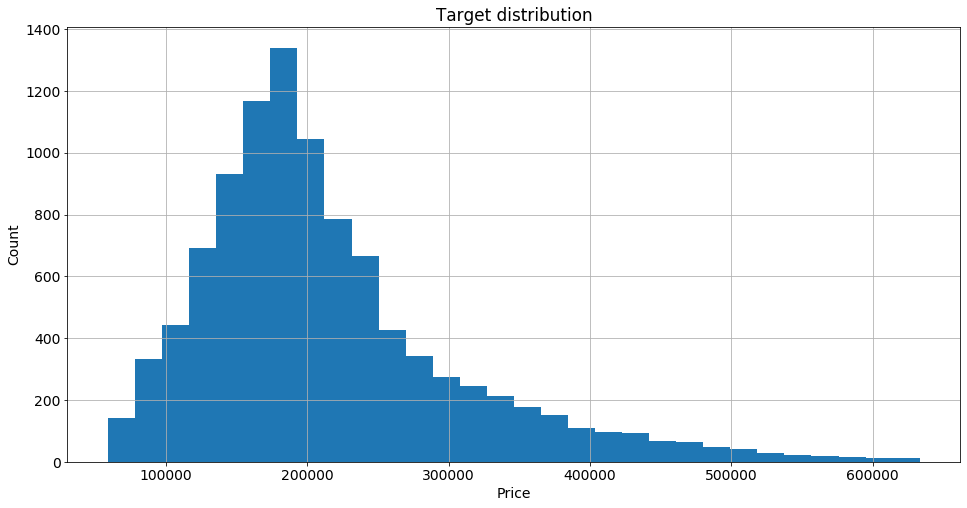

In [19]:
plt.figure(figsize = (16, 8))

train_df['Price'].hist(bins=30)
plt.ylabel('Count')
plt.xlabel('Price')

plt.title('Target distribution')
plt.show()

### Обзор количественных переменных

In [20]:
data_num_features = data.select_dtypes(include=['float64', 'int64'])
data_num_features.head()

,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Price
0,2.0,47.981561,29.442751,6.0,7,9.0,1969,0.089040,33,7976,5,NaN,0,11,184966.930730
1,3.0,65.683640,40.049543,8.0,7,9.0,1978,0.000070,46,10309,1,240.0,1,16,300009.450063
2,2.0,44.947953,29.197612,0.0,8,12.0,1968,0.049637,34,7759,0,229.0,1,3,220925.908524
3,2.0,53.352981,52.731512,9.0,8,17.0,1977,0.437885,23,5735,3,1084.0,0,5,175616.227217
4,1.0,39.649192,23.776169,7.0,11,12.0,1976,0.012339,35,5776,1,2078.0,2,4,150226.531644


In [21]:
data.isnull().sum()

Id                  0
DistrictId          0
Rooms               0
Square              0
LifeSquare       3154
KitchenSquare       0
Floor               0
HouseFloor          0
HouseYear           0
Ecology_1           0
Ecology_2           0
Ecology_3           0
Social_1            0
Social_2            0
Social_3            0
Healthcare_1     7175
Helthcare_2         0
Shops_1             0
Shops_2             0
Price            5000
dtype: int64

In [22]:
data.describe()

,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Price
count,15000.000000,15000.000000,11846.000000,15000.000000,15000.000000,15000.000000,1.500000e+04,15000.000000,15000.000000,15000.000000,15000.000000,7825.000000,15000.000000,15000.000000,10000.000000
mean,1.897000,56.360350,36.851792,6.174467,8.561800,12.606600,3.321575e+03,0.119196,24.769267,5370.404933,8.113667,1144.162428,1.319467,4.235133,214138.857399
std,0.839229,20.423913,71.120183,24.016979,5.323113,6.780165,1.637078e+05,0.119371,17.532278,4013.364403,23.841946,1029.296278,1.489012,4.796545,92872.293865
min,0.000000,1.136859,0.333490,0.000000,1.000000,0.000000,1.908000e+03,0.000000,0.000000,168.000000,0.000000,0.000000,0.000000,0.000000,59174.778028
25%,1.000000,41.814371,22.896130,1.000000,4.000000,9.000000,1.974000e+03,0.017647,6.000000,1564.000000,0.000000,350.000000,0.000000,1.000000,153872.633942
50%,2.000000,52.645757,32.822810,6.000000,7.000000,12.000000,1.977000e+03,0.075424,25.000000,5285.000000,2.000000,900.000000,1.000000,3.000000,192269.644879
75%,2.000000,66.036608,45.144624,9.000000,12.000000,17.000000,2.001000e+03,0.195781,36.000000,7287.000000,5.000000,1548.000000,2.000000,6.000000,249135.462171
max,19.000000,641.065193,7480.592129,2014.000000,78.000000,117.000000,2.005201e+07,0.521867,74.000000,19083.000000,141.000000,4849.000000,6.000000,23.000000,633233.466570


 ## Обзор номинативных переменных

In [23]:
data_obj_features = data.select_dtypes(include='object')
data_obj_features.head()

,Id,DistrictId,Ecology_2,Ecology_3,Shops_2
0,14038,35,B,B,B
1,15053,41,B,B,B
2,4765,53,B,B,B
3,5809,58,B,B,B
4,10783,99,B,B,B


In [24]:
for cat_features in data_obj_features.columns.tolist()[2:]:
    print(f'{cat_features}\n{data[cat_features].value_counts()}\n\n')

Ecology_2
B    14855
A      145
Name: Ecology_2, dtype: int64


Ecology_3
B    14576
A      424
Name: Ecology_3, dtype: int64


Shops_2
B    13763
A     1237
Name: Shops_2, dtype: int64




### Обработка пропусков и выбросов по каждому признаку

In [25]:
data.isnull().sum()

Id                  0
DistrictId          0
Rooms               0
Square              0
LifeSquare       3154
KitchenSquare       0
Floor               0
HouseFloor          0
HouseYear           0
Ecology_1           0
Ecology_2           0
Ecology_3           0
Social_1            0
Social_2            0
Social_3            0
Healthcare_1     7175
Helthcare_2         0
Shops_1             0
Shops_2             0
Price            5000
dtype: int64

**DistrictId**

In [26]:
data['DistrictId'].value_counts()

27     1242
1       996
23      829
6       768
9       426
       ... 
198       1
210       1
199       1
204       1
211       1
Name: DistrictId, Length: 212, dtype: int64

In [27]:
data['DistrictId'].value_counts(normalize=True)

27     0.082800
1      0.066400
23     0.055267
6      0.051200
9      0.028400
         ...   
198    0.000067
210    0.000067
199    0.000067
204    0.000067
211    0.000067
Name: DistrictId, Length: 212, dtype: float64

In [28]:
data.loc[data['DistrictId'] == '0', :]

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
20,8862,0,3.0,103.605292,47.799426,10.0,12,17.0,2002,0.319809,B,B,25,4756,16,2857.0,5,8,B,521919.057400
636,14492,0,2.0,62.962156,37.043238,10.0,10,22.0,2007,0.319809,B,B,25,4756,16,2857.0,5,8,B,334328.590220
745,9982,0,3.0,89.636583,49.965887,10.0,1,17.0,2009,0.006076,B,B,30,5285,0,645.0,6,6,B,184968.357821
1188,9302,0,1.0,36.158717,24.286117,5.0,2,5.0,1963,0.319809,B,B,25,4756,16,2857.0,5,8,B,147258.736617
1539,3808,0,3.0,76.585035,52.310864,8.0,4,8.0,1960,0.319809,B,B,25,4756,16,2857.0,5,8,B,339228.823764
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14094,4637,0,4.0,107.161349,67.035133,10.0,10,22.0,2007,0.319809,B,B,25,4756,16,2857.0,5,8,B,NaN
14561,4836,0,3.0,57.966829,37.290753,5.0,3,8.0,1963,0.319809,B,B,25,4756,16,2857.0,5,8,B,NaN
14706,9924,0,3.0,58.077266,39.105198,5.0,4,5.0,1963,0.319809,B,B,25,4756,16,2857.0,5,8,B,NaN
14739,3260,0,2.0,43.489378,25.097347,5.0,1,5.0,1962,0.319809,B,B,25,4756,16,2857.0,5,8,B,NaN


In [29]:
data.loc[data['DistrictId'] == '0', 'DistrictId'].count()

67

полагаю, что district = 0, это реальный id района, не выброс, так как показатели по столбцам экологии, магазинам и healthcare у них почти все одинаковые, значит скорее всего это реальный район с id = 0

In [30]:
data['DistrictId'] = data['DistrictId'].astype('int64')
data['DistrictId'].dtype

dtype('int64')

In [31]:
# проверю, сколько вариантов экологии в одном районе
for x in data['DistrictId'].sort_values().unique():
    if len(data.loc[data['DistrictId'] == x, 'Ecology_2'].unique()) != 1:
        print(x, len(data.loc[data['DistrictId'] == x, 'Ecology_2'].unique()))

11 2
57 2
71 2
101 2
192 2


**Rooms**

In [32]:
data['Rooms'].value_counts()

2.0     5910
1.0     5474
3.0     3334
4.0      240
5.0       25
0.0       10
6.0        3
10.0       2
19.0       1
17.0       1
Name: Rooms, dtype: int64

In [33]:
test_df['Rooms'].value_counts()

2.0     2030
1.0     1769
3.0     1099
4.0       90
5.0        7
0.0        2
6.0        2
17.0       1
Name: Rooms, dtype: int64

In [34]:
data.loc[data['Rooms'].isin([0, 5, 6, 10, 17, 19])]

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
377,5927,57,10.0,59.056975,36.223072,10.0,22,22.0,2002,0.090799,B,B,74,19083,2,NaN,5,15,B,317265.323792
1397,12638,27,0.0,138.427694,136.215499,0.0,4,3.0,2016,0.075424,B,B,11,3097,0,NaN,0,0,B,268394.744389
1422,4282,195,5.0,95.617533,62.377052,7.0,7,7.0,1940,0.015017,B,B,17,3079,59,2890.0,0,8,B,479525.147323
1454,8491,1,19.0,42.006046,21.779288,7.0,17,17.0,2014,0.007122,B,B,1,264,0,NaN,0,1,B,78364.616704
1503,1243,86,5.0,108.057398,82.723825,8.0,3,5.0,1942,0.161976,B,A,31,7010,5,4508.0,3,7,B,310305.074733
1981,7917,27,0.0,212.932361,211.231125,0.0,2,3.0,2008,0.211401,B,B,9,1892,0,NaN,0,1,B,302211.260887
1982,5548,86,5.0,275.645284,233.949309,26.0,12,37.0,2011,0.161976,B,A,31,7010,5,4508.0,3,7,B,455264.882666
2170,14003,99,6.0,59.414334,38.702244,6.0,7,9.0,1969,0.033494,B,B,66,10573,1,1322.0,3,8,B,229661.964416
2269,7317,27,0.0,41.790881,NaN,0.0,13,0.0,1977,0.211401,B,B,9,1892,0,NaN,0,1,B,98129.976788
3268,8901,34,5.0,121.577423,114.913843,1.0,25,1.0,1977,0.069753,B,B,53,13670,4,NaN,1,11,B,455446.393758


In [35]:
data['Rooms'].median()

2.0

In [36]:
data.loc[data['Rooms'].isin([0, 5, 6, 10, 17, 19]), 'Rooms'] = data['Rooms'].median()

In [37]:
data['Rooms'].value_counts()

2.0    5952
1.0    5474
3.0    3334
4.0     240
Name: Rooms, dtype: int64

**Square, LifeSquare, KitchenSquare**

In [38]:
data[['Square', 'LifeSquare', 'KitchenSquare']].head(10)

,Square,LifeSquare,KitchenSquare
0,47.981561,29.442751,6.0
1,65.683640,40.049543,8.0
2,44.947953,29.197612,0.0
3,53.352981,52.731512,9.0
4,39.649192,23.776169,7.0
5,80.384479,46.683720,12.0
6,62.254114,37.160377,7.0
7,80.312926,NaN,0.0
8,64.511437,NaN,1.0
9,46.461409,18.915552,8.0


In [39]:
data["LifeSquare"].isnull().sum()

3154

In [40]:
data.describe()

,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Price
count,15000.000000,15000.000000,15000.000000,11846.000000,15000.000000,15000.000000,15000.000000,1.500000e+04,15000.000000,15000.000000,15000.000000,15000.000000,7825.000000,15000.000000,15000.000000,10000.000000
mean,50.693600,1.889333,56.360350,36.851792,6.174467,8.561800,12.606600,3.321575e+03,0.119196,24.769267,5370.404933,8.113667,1144.162428,1.319467,4.235133,214138.857399
std,43.786257,0.799372,20.423913,71.120183,24.016979,5.323113,6.780165,1.637078e+05,0.119371,17.532278,4013.364403,23.841946,1029.296278,1.489012,4.796545,92872.293865
min,0.000000,1.000000,1.136859,0.333490,0.000000,1.000000,0.000000,1.908000e+03,0.000000,0.000000,168.000000,0.000000,0.000000,0.000000,0.000000,59174.778028
25%,20.000000,1.000000,41.814371,22.896130,1.000000,4.000000,9.000000,1.974000e+03,0.017647,6.000000,1564.000000,0.000000,350.000000,0.000000,1.000000,153872.633942
50%,37.000000,2.000000,52.645757,32.822810,6.000000,7.000000,12.000000,1.977000e+03,0.075424,25.000000,5285.000000,2.000000,900.000000,1.000000,3.000000,192269.644879
75%,75.000000,2.000000,66.036608,45.144624,9.000000,12.000000,17.000000,2.001000e+03,0.195781,36.000000,7287.000000,5.000000,1548.000000,2.000000,6.000000,249135.462171
max,212.000000,4.000000,641.065193,7480.592129,2014.000000,78.000000,117.000000,2.005201e+07,0.521867,74.000000,19083.000000,141.000000,4849.000000,6.000000,23.000000,633233.466570


In [41]:
data.loc[data['Square'] < 10, :]

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
212,1748,88,2.0,5.497061,67.628717,1.0,24,22.0,1977,0.127376,B,B,43,8429,3,NaN,3,9,B,412511.088764
1316,11526,27,1.0,4.633498,1.969969,1.0,18,1.0,1977,0.011654,B,B,4,915,0,NaN,0,0,B,107604.269441
1608,10202,6,1.0,2.596351,4.604943,1.0,3,25.0,2014,0.243205,B,B,5,1564,0,540.0,0,0,B,137597.601458
3280,10527,27,1.0,4.380726,40.805837,1.0,10,17.0,2013,0.211401,B,B,9,1892,0,NaN,0,1,B,97560.720383
3413,9487,5,1.0,5.129222,5.549458,1.0,1,1.0,1977,0.150818,B,B,16,3433,4,2643.0,4,5,B,369472.403061
4853,3224,27,2.0,2.377248,0.873147,0.0,1,0.0,1977,0.017647,B,B,2,469,0,NaN,0,0,B,126596.941798
4900,4504,27,3.0,4.390331,5.610772,1.0,8,19.0,2016,0.211401,B,B,9,1892,0,NaN,0,1,B,161379.067034
6392,14786,1,1.0,1.136859,4.525736,1.0,3,1.0,1977,0.007122,B,B,1,264,0,NaN,0,1,B,181434.825589
8030,13265,1,3.0,4.823679,79.767964,0.0,6,17.0,1977,0.007122,B,B,1,264,0,NaN,0,1,B,237716.681261
8283,15744,34,1.0,1.988943,2.642219,1.0,21,4.0,1977,0.069753,B,B,53,13670,4,NaN,1,11,B,458378.777006


In [42]:
data.loc[data['LifeSquare'] / data['Square'] >= 4] # здесь ошибка в запятой скорее всего в Square или LifeSquare, исправим ее

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
212,1748,88,2.0,5.497061,67.628717,1.0,24,22.0,1977,0.127376,B,B,43,8429,3,NaN,3,9,B,412511.088764
590,14990,23,2.0,48.449873,263.542020,5.0,6,5.0,1972,0.075779,B,B,6,1437,3,NaN,0,2,B,141780.231857
3280,10527,27,1.0,4.380726,40.805837,1.0,10,17.0,2013,0.211401,B,B,9,1892,0,NaN,0,1,B,97560.720383
4328,16550,27,3.0,81.694417,7480.592129,1.0,9,17.0,2016,0.017647,B,B,2,469,0,NaN,0,0,B,217357.492366
6332,8961,27,1.0,33.398983,164.153360,6.0,3,5.0,1965,0.211401,B,B,9,1892,0,NaN,0,1,B,104891.073757
8030,13265,1,3.0,4.823679,79.767964,0.0,6,17.0,1977,0.007122,B,B,1,264,0,NaN,0,1,B,237716.681261
8437,15886,85,3.0,78.059331,461.463614,10.0,12,16.0,1998,0.037178,B,B,52,11217,1,2300.0,1,7,B,394253.299978
10410,11533,94,2.0,48.713443,303.071094,6.0,5,12.0,1974,0.521867,B,B,25,6149,0,NaN,0,0,B,NaN
14713,170,6,2.0,2.900586,61.468563,1.0,18,17.0,2014,0.243205,B,B,5,1564,0,540.0,0,0,B,NaN


In [43]:
data.loc[data['Id'] == '10527', 'Square'] = data.loc[data['Id'] == '10527', 'Square'] * 10 

In [44]:
data.loc[data['LifeSquare'] / data['Square'] >= 4]

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
212,1748,88,2.0,5.497061,67.628717,1.0,24,22.0,1977,0.127376,B,B,43,8429,3,NaN,3,9,B,412511.088764
590,14990,23,2.0,48.449873,263.542020,5.0,6,5.0,1972,0.075779,B,B,6,1437,3,NaN,0,2,B,141780.231857
4328,16550,27,3.0,81.694417,7480.592129,1.0,9,17.0,2016,0.017647,B,B,2,469,0,NaN,0,0,B,217357.492366
6332,8961,27,1.0,33.398983,164.153360,6.0,3,5.0,1965,0.211401,B,B,9,1892,0,NaN,0,1,B,104891.073757
8030,13265,1,3.0,4.823679,79.767964,0.0,6,17.0,1977,0.007122,B,B,1,264,0,NaN,0,1,B,237716.681261
8437,15886,85,3.0,78.059331,461.463614,10.0,12,16.0,1998,0.037178,B,B,52,11217,1,2300.0,1,7,B,394253.299978
10410,11533,94,2.0,48.713443,303.071094,6.0,5,12.0,1974,0.521867,B,B,25,6149,0,NaN,0,0,B,NaN
14713,170,6,2.0,2.900586,61.468563,1.0,18,17.0,2014,0.243205,B,B,5,1564,0,540.0,0,0,B,NaN


In [45]:
data.loc[data['LifeSquare'] / data['Square'] >= 4, 'LifeSquare'] = data.loc[data['LifeSquare'] / data['Square'] >= 4, 'LifeSquare'] / 10 

In [46]:
data.loc[data['LifeSquare'] / data['Square'] >= 4]

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
4328,16550,27,3.0,81.694417,748.059213,1.0,9,17.0,2016,0.017647,B,B,2,469,0,NaN,0,0,B,217357.492366


In [47]:
data.loc[data['Id'] == '16550', 'LifeSquare'] = data.loc[data['Id'] == '16550', 'LifeSquare'] / 10 

In [48]:
data.loc[data['LifeSquare'] <= 1]

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
26,4378,27,3.0,106.958871,0.641822,0.0,17,0.0,2018,0.072158,B,B,2,629,1,NaN,0,0,A,337299.867936
4853,3224,27,2.0,2.377248,0.873147,0.0,1,0.0,1977,0.017647,B,B,2,469,0,NaN,0,0,B,126596.941798
6609,13491,0,1.0,38.178277,0.370619,0.0,19,17.0,2016,0.006076,B,B,30,5285,0,645.0,6,6,B,105134.286994
9602,5112,6,2.0,63.591740,0.795539,10.0,17,17.0,2014,0.243205,B,B,5,1564,0,540.0,0,0,B,174741.998061
10078,6553,34,2.0,122.375273,0.333490,0.0,9,0.0,1977,0.069753,B,B,53,13670,4,NaN,1,11,B,NaN
12341,3028,9,1.0,43.348348,0.809265,0.0,16,17.0,2015,0.161532,B,B,25,5648,1,30.0,2,4,B,NaN
12398,13014,53,3.0,81.141636,0.863989,0.0,10,1.0,2017,0.049637,B,B,34,7759,0,229.0,1,3,B,NaN
12992,6406,27,2.0,66.469510,0.567267,0.0,4,0.0,2018,0.017647,B,B,2,469,0,NaN,0,0,B,NaN


In [49]:
data.loc[(data['LifeSquare'] <= 1) & (data['Id'] != '3224')]

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
26,4378,27,3.0,106.958871,0.641822,0.0,17,0.0,2018,0.072158,B,B,2,629,1,NaN,0,0,A,337299.867936
6609,13491,0,1.0,38.178277,0.370619,0.0,19,17.0,2016,0.006076,B,B,30,5285,0,645.0,6,6,B,105134.286994
9602,5112,6,2.0,63.591740,0.795539,10.0,17,17.0,2014,0.243205,B,B,5,1564,0,540.0,0,0,B,174741.998061
10078,6553,34,2.0,122.375273,0.333490,0.0,9,0.0,1977,0.069753,B,B,53,13670,4,NaN,1,11,B,NaN
12341,3028,9,1.0,43.348348,0.809265,0.0,16,17.0,2015,0.161532,B,B,25,5648,1,30.0,2,4,B,NaN
12398,13014,53,3.0,81.141636,0.863989,0.0,10,1.0,2017,0.049637,B,B,34,7759,0,229.0,1,3,B,NaN
12992,6406,27,2.0,66.469510,0.567267,0.0,4,0.0,2018,0.017647,B,B,2,469,0,NaN,0,0,B,NaN


In [50]:
data.loc[(data['LifeSquare'] <= 1) & (data['Id'] != '3224'), 'LifeSquare'] = data.loc[(data['LifeSquare'] <= 1) & (data['Id'] != '3224'), 'LifeSquare'] * 100

In [51]:
data.loc[(data['Square'] / data['LifeSquare'] >= 4)]

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
95,4280,34,2.0,61.334968,4.091945,1.0,26,1.0,2014,0.069753,B,B,53,13670,4,NaN,1,11,B,286564.441972
134,12613,6,2.0,65.496674,5.589324,1.0,5,17.0,1977,0.243205,B,B,5,1564,0,540.0,0,0,B,180727.643541
158,16779,27,3.0,51.991064,4.896202,1.0,22,25.0,1977,0.072158,B,B,2,629,1,NaN,0,0,A,174687.566186
160,3522,6,1.0,66.419841,3.987101,1.0,2,1.0,1977,0.243205,B,B,5,1564,0,540.0,0,0,B,193361.229815
270,15215,17,1.0,46.692974,5.941401,1.0,7,1.0,2015,0.000000,B,B,18,3374,5,620.0,1,2,B,212290.684086
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14795,9969,45,1.0,42.491500,3.466208,1.0,4,2.0,2018,0.195781,B,B,23,5212,6,NaN,3,2,B,NaN
14818,8963,27,3.0,79.114387,3.329216,1.0,3,22.0,1977,0.211401,B,B,9,1892,0,NaN,0,1,B,NaN
14846,5002,1,3.0,82.624843,4.379317,1.0,5,17.0,2016,0.007122,B,B,1,264,0,NaN,0,1,B,NaN
14863,4611,27,2.0,76.709543,2.989508,1.0,13,12.0,2016,0.072158,B,B,2,629,1,NaN,0,0,A,NaN


In [52]:
data.loc[(data['Square'] / data['LifeSquare'] >= 4), 'LifeSquare'] = data.loc[(data['Square'] / data['LifeSquare'] >= 4), 'LifeSquare'] * 10

In [53]:
data.loc[(data['Square'] / data['LifeSquare'] >= 4)] # эти уже непонятна причина, возможно, так и есть

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
683,15091,27,2.0,66.535842,16.380827,1.0,6,1.0,1977,0.017647,B,B,2,469,0,NaN,0,0,B,175067.233991
751,11989,62,3.0,104.446306,14.510667,1.0,12,15.0,2015,0.072158,B,B,2,629,1,NaN,0,0,A,223692.672480
1918,13603,63,1.0,127.651237,26.097116,1.0,8,17.0,2016,0.238617,B,B,26,3889,6,705.0,3,6,B,594565.299770
2142,15261,22,3.0,83.162217,13.182499,1.0,8,1.0,2018,0.118537,B,B,30,6207,1,1183.0,1,0,B,391390.261824
2887,15402,27,2.0,58.521098,10.498673,1.0,4,17.0,2014,0.072158,B,B,2,629,1,NaN,0,0,A,142393.084641
3072,1388,54,2.0,74.747303,14.111011,1.0,7,22.0,1977,0.006076,B,B,30,5285,0,645.0,6,6,B,431137.951634
3468,88,34,4.0,93.904994,20.786885,1.0,14,1.0,2018,0.069753,B,B,53,13670,4,NaN,1,11,B,367368.954516
3730,12049,1,2.0,61.541353,12.422499,1.0,20,22.0,2014,0.007122,B,B,1,264,0,NaN,0,1,B,206168.319222
4037,5762,27,2.0,67.983723,14.714908,1.0,8,1.0,2019,0.211401,B,B,9,1892,0,NaN,0,1,B,152932.624905
4268,6631,85,1.0,48.990533,11.046892,1.0,5,17.0,1977,0.072158,B,B,2,629,1,NaN,0,0,A,124761.832592


In [54]:
data.loc[data['Square'] < 10, :]

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
212,1748,88,2.0,5.497061,6.762872,1.0,24,22.0,1977,0.127376,B,B,43,8429,3,NaN,3,9,B,412511.088764
1316,11526,27,1.0,4.633498,1.969969,1.0,18,1.0,1977,0.011654,B,B,4,915,0,NaN,0,0,B,107604.269441
1608,10202,6,1.0,2.596351,4.604943,1.0,3,25.0,2014,0.243205,B,B,5,1564,0,540.0,0,0,B,137597.601458
3413,9487,5,1.0,5.129222,5.549458,1.0,1,1.0,1977,0.150818,B,B,16,3433,4,2643.0,4,5,B,369472.403061
4853,3224,27,2.0,2.377248,0.873147,0.0,1,0.0,1977,0.017647,B,B,2,469,0,NaN,0,0,B,126596.941798
4900,4504,27,3.0,4.390331,5.610772,1.0,8,19.0,2016,0.211401,B,B,9,1892,0,NaN,0,1,B,161379.067034
6392,14786,1,1.0,1.136859,4.525736,1.0,3,1.0,1977,0.007122,B,B,1,264,0,NaN,0,1,B,181434.825589
8030,13265,1,3.0,4.823679,7.976796,0.0,6,17.0,1977,0.007122,B,B,1,264,0,NaN,0,1,B,237716.681261
8283,15744,34,1.0,1.988943,2.642219,1.0,21,4.0,1977,0.069753,B,B,53,13670,4,NaN,1,11,B,458378.777006
9294,6782,45,1.0,2.954309,5.257278,1.0,3,1.0,1977,0.195781,B,B,23,5212,6,NaN,3,2,B,438005.182323


In [55]:
data.loc[data['LifeSquare'] < 10, :] # оставим, как есть

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
212,1748,88,2.0,5.497061,6.762872,1.0,24,22.0,1977,0.127376,B,B,43,8429,3,NaN,3,9,B,412511.088764
1316,11526,27,1.0,4.633498,1.969969,1.0,18,1.0,1977,0.011654,B,B,4,915,0,NaN,0,0,B,107604.269441
1608,10202,6,1.0,2.596351,4.604943,1.0,3,25.0,2014,0.243205,B,B,5,1564,0,540.0,0,0,B,137597.601458
3413,9487,5,1.0,5.129222,5.549458,1.0,1,1.0,1977,0.150818,B,B,16,3433,4,2643.0,4,5,B,369472.403061
4853,3224,27,2.0,2.377248,0.873147,0.0,1,0.0,1977,0.017647,B,B,2,469,0,NaN,0,0,B,126596.941798
4900,4504,27,3.0,4.390331,5.610772,1.0,8,19.0,2016,0.211401,B,B,9,1892,0,NaN,0,1,B,161379.067034
6392,14786,1,1.0,1.136859,4.525736,1.0,3,1.0,1977,0.007122,B,B,1,264,0,NaN,0,1,B,181434.825589
7767,6927,21,1.0,16.117154,8.822988,0.0,2,5.0,1965,0.194489,B,B,47,8004,3,125.0,3,5,B,79913.267856
8030,13265,1,3.0,4.823679,7.976796,0.0,6,17.0,1977,0.007122,B,B,1,264,0,NaN,0,1,B,237716.681261
8283,15744,34,1.0,1.988943,2.642219,1.0,21,4.0,1977,0.069753,B,B,53,13670,4,NaN,1,11,B,458378.777006


In [56]:
data.loc[data['Square'] < data['LifeSquare']]

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
28,8054,23,1.0,42.530043,43.967759,1.0,3,9.0,2014,0.034656,B,B,0,168,0,NaN,0,0,B,95338.198549
44,10521,38,3.0,104.211396,106.340403,0.0,20,0.0,2017,0.060753,B,B,15,2787,2,520.0,0,7,B,435462.048070
52,2301,1,2.0,61.400054,65.224603,0.0,17,22.0,2016,0.007122,B,B,1,264,0,NaN,0,1,B,199215.452229
123,8753,25,3.0,85.952306,89.803753,1.0,4,3.0,2017,0.069753,B,B,53,13670,4,NaN,1,11,B,309688.592681
153,9870,62,1.0,51.831473,53.491301,1.0,5,1.0,2015,0.072158,B,B,2,629,1,NaN,0,0,A,131797.472284
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14927,14686,1,3.0,77.229885,79.958685,1.0,18,17.0,1977,0.007122,B,B,1,264,0,NaN,0,1,B,NaN
14951,3711,94,1.0,41.281057,42.392594,10.0,13,13.0,2014,0.282798,B,B,33,8667,2,NaN,0,6,B,NaN
14962,5820,94,1.0,33.680382,34.198977,1.0,10,9.0,1972,0.127376,B,B,43,8429,3,NaN,3,9,B,NaN
14969,4821,74,2.0,82.542507,82.585069,0.0,4,17.0,2015,0.309479,B,B,35,7715,4,990.0,0,6,B,NaN


In [57]:
# предположим что перепутали жилую с общей
mask = data['Square'] < data['LifeSquare']
data_to_change = data.loc[mask]
mask.sum()

769

In [58]:
data.loc[data_to_change.index, 'Square'], data.loc[data_to_change.index, 'LifeSquare'] = data.loc[data_to_change.index, 'LifeSquare'], data.loc[data_to_change.index, 'Square']

In [59]:
mask = data['Square'] < data['LifeSquare']
data_to_change = data.loc[mask]
mask.sum()

0

In [60]:
data.loc[(data['KitchenSquare'] > 30)]

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
227,16395,2,3.0,79.722243,44.731219,72.0,12,16.0,1987,0.130618,B,B,39,10418,9,900.0,1,9,B,370148.625285
551,1315,6,1.0,48.128114,45.023531,48.0,21,1.0,2013,0.243205,B,B,5,1564,0,540.0,0,0,B,146950.912410
1064,14656,62,1.0,47.100719,46.447960,2014.0,4,1.0,2014,0.072158,B,B,2,629,1,NaN,0,0,A,108337.484207
1077,9690,27,1.0,40.081042,37.834964,37.0,18,19.0,2019,0.211401,B,B,9,1892,0,NaN,0,1,B,93218.650461
1369,2371,27,2.0,68.841073,64.234956,66.0,4,2.0,2014,0.017647,B,B,2,469,0,NaN,0,0,B,189244.249909
1455,12507,54,2.0,79.810535,79.578961,78.0,10,15.0,2014,0.006076,B,B,30,5285,0,645.0,6,6,B,438708.707579
1860,4265,161,2.0,53.216778,32.644859,53.0,7,17.0,1994,0.000699,B,B,14,3369,24,4129.0,0,3,B,261125.669724
1867,3267,58,3.0,138.980817,138.004600,43.0,2,2.0,1977,0.437885,B,B,23,5735,3,1084.0,0,5,B,169528.896664
2916,12390,72,3.0,99.323558,97.490674,96.0,22,25.0,2019,0.210473,B,B,11,2398,2,1994.0,3,0,B,445074.956552
2969,7441,62,3.0,114.734473,112.589083,112.0,3,3.0,2015,0.072158,B,B,2,629,1,NaN,0,0,A,315245.521059


In [61]:
data.loc[data['Id'].isin(['16593', '5428']), 'LifeSquare'] = data.loc[data['Id'].isin(['16593', '5428']), 'KitchenSquare']

In [62]:
data.loc[(data['KitchenSquare'] > 30)]

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
227,16395,2,3.0,79.722243,44.731219,72.0,12,16.0,1987,0.130618,B,B,39,10418,9,900.0,1,9,B,370148.625285
551,1315,6,1.0,48.128114,45.023531,48.0,21,1.0,2013,0.243205,B,B,5,1564,0,540.0,0,0,B,146950.912410
1064,14656,62,1.0,47.100719,46.447960,2014.0,4,1.0,2014,0.072158,B,B,2,629,1,NaN,0,0,A,108337.484207
1077,9690,27,1.0,40.081042,37.834964,37.0,18,19.0,2019,0.211401,B,B,9,1892,0,NaN,0,1,B,93218.650461
1369,2371,27,2.0,68.841073,64.234956,66.0,4,2.0,2014,0.017647,B,B,2,469,0,NaN,0,0,B,189244.249909
1455,12507,54,2.0,79.810535,79.578961,78.0,10,15.0,2014,0.006076,B,B,30,5285,0,645.0,6,6,B,438708.707579
1860,4265,161,2.0,53.216778,32.644859,53.0,7,17.0,1994,0.000699,B,B,14,3369,24,4129.0,0,3,B,261125.669724
1867,3267,58,3.0,138.980817,138.004600,43.0,2,2.0,1977,0.437885,B,B,23,5735,3,1084.0,0,5,B,169528.896664
2916,12390,72,3.0,99.323558,97.490674,96.0,22,25.0,2019,0.210473,B,B,11,2398,2,1994.0,3,0,B,445074.956552
2969,7441,62,3.0,114.734473,112.589083,112.0,3,3.0,2015,0.072158,B,B,2,629,1,NaN,0,0,A,315245.521059


In [63]:
data.loc[(data['KitchenSquare'] > 30) & (data['KitchenSquare'] >= data['Square'] - data['LifeSquare'])]

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
227,16395,2,3.0,79.722243,44.731219,72.0,12,16.0,1987,0.130618,B,B,39,10418,9,900.0,1,9,B,370148.625285
551,1315,6,1.0,48.128114,45.023531,48.0,21,1.0,2013,0.243205,B,B,5,1564,0,540.0,0,0,B,146950.912410
1064,14656,62,1.0,47.100719,46.447960,2014.0,4,1.0,2014,0.072158,B,B,2,629,1,NaN,0,0,A,108337.484207
1077,9690,27,1.0,40.081042,37.834964,37.0,18,19.0,2019,0.211401,B,B,9,1892,0,NaN,0,1,B,93218.650461
1369,2371,27,2.0,68.841073,64.234956,66.0,4,2.0,2014,0.017647,B,B,2,469,0,NaN,0,0,B,189244.249909
1455,12507,54,2.0,79.810535,79.578961,78.0,10,15.0,2014,0.006076,B,B,30,5285,0,645.0,6,6,B,438708.707579
1860,4265,161,2.0,53.216778,32.644859,53.0,7,17.0,1994,0.000699,B,B,14,3369,24,4129.0,0,3,B,261125.669724
1867,3267,58,3.0,138.980817,138.004600,43.0,2,2.0,1977,0.437885,B,B,23,5735,3,1084.0,0,5,B,169528.896664
2916,12390,72,3.0,99.323558,97.490674,96.0,22,25.0,2019,0.210473,B,B,11,2398,2,1994.0,3,0,B,445074.956552
2969,7441,62,3.0,114.734473,112.589083,112.0,3,3.0,2015,0.072158,B,B,2,629,1,NaN,0,0,A,315245.521059


In [64]:
data['KitchenSquare'].median()

6.0

In [65]:
data.loc[(data['KitchenSquare'] > 30) & (data['KitchenSquare'] >= data['Square'] - data['LifeSquare']), 'KitchenSquare'] = data['KitchenSquare'].median()

In [66]:
data.loc[(data['KitchenSquare'] > 30)]

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
3431,7111,27,2.0,139.070296,89.787666,42.0,5,3.0,2016,0.014073,B,B,2,475,0,NaN,0,0,B,153946.777452
5087,15947,129,4.0,185.906396,84.830074,31.0,5,3.0,2015,0.020741,B,B,24,5613,5,1340.0,2,5,B,340273.238253
5494,300,31,2.0,106.427686,34.230415,32.0,4,40.0,2013,0.151346,B,A,32,5889,10,830.0,4,1,B,624549.354546
7201,3233,129,4.0,186.692602,87.487080,32.0,3,3.0,2011,0.020741,B,B,24,5613,5,1340.0,2,5,B,423443.464367
10803,3747,23,2.0,139.045763,89.790274,42.0,1,3.0,2015,0.014073,B,B,2,475,0,NaN,0,0,B,NaN
10870,13736,27,1.0,141.540215,91.704806,42.0,3,3.0,2013,0.014073,B,B,2,475,0,NaN,0,0,B,NaN
11447,1968,27,2.0,138.039182,92.484098,42.0,3,3.0,2016,0.014073,B,B,2,475,0,NaN,0,0,B,NaN


In [67]:
data.loc[(data['KitchenSquare'] == 0)]

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
2,4765,53,2.0,44.947953,29.197612,0.0,8,12.0,1968,0.049637,B,B,34,7759,0,229.0,1,3,B,220925.908524
7,11993,74,2.0,80.312926,NaN,0.0,14,0.0,1977,0.075779,B,B,6,1437,3,NaN,0,2,B,221244.156664
23,6641,54,3.0,118.907612,NaN,0.0,2,0.0,1977,0.006076,B,B,30,5285,0,645.0,6,6,B,571069.052600
26,4378,27,3.0,106.958871,64.182211,0.0,17,0.0,2018,0.072158,B,B,2,629,1,NaN,0,0,A,337299.867936
39,9371,23,2.0,60.503248,NaN,0.0,16,0.0,1977,0.034656,B,B,0,168,0,NaN,0,0,B,229778.057902
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14969,4821,74,2.0,82.585069,82.542507,0.0,4,17.0,2015,0.309479,B,B,35,7715,4,990.0,0,6,B,NaN
14973,1804,27,1.0,38.916778,NaN,0.0,11,17.0,1977,0.011654,B,B,4,915,0,NaN,0,0,B,NaN
14974,5296,52,1.0,44.634608,44.442218,0.0,5,17.0,1977,0.371149,B,B,34,7065,1,750.0,2,5,B,NaN
14976,4723,95,1.0,45.542940,NaN,0.0,6,0.0,1977,0.000699,B,B,14,3369,24,4129.0,0,3,B,NaN


In [68]:
data['KitchenSquare'].value_counts()

1.0     3651
8.0     1912
5.0     1781
6.0     1678
10.0    1633
9.0     1260
0.0     1032
7.0      906
12.0     381
11.0     340
13.0     100
14.0      71
4.0       60
15.0      48
3.0       33
16.0      29
17.0      17
20.0      16
19.0      13
18.0       9
2.0        8
42.0       4
22.0       4
30.0       3
32.0       2
25.0       2
21.0       1
27.0       1
31.0       1
29.0       1
23.0       1
26.0       1
24.0       1
Name: KitchenSquare, dtype: int64

In [69]:
data.loc[data['KitchenSquare'] < 1, 'KitchenSquare'] = 1

In [70]:
data['Square'].sort_values(ascending = False).head()

6977    641.065193
4262    604.705972
4690    410.639749
1982    275.645284
3723    226.303731
Name: Square, dtype: float64

In [71]:
x_test['Square'].sort_values(ascending = False).head()


13217    223.453689
13909    221.138768
11499    189.679576
11264    173.974480
12039    170.476326
Name: Square, dtype: float64

In [72]:
list(data[data['Square'] > 300].index)

[4262, 4690, 6977]

In [73]:
# так как в тесте нет квартир площадью больше 224 метров, я уберу совсем из трейна квартиры с площадью более 300 метров
data = data.drop(data[data['Square'] > 300].index)

In [74]:
data['Square'].sort_values(ascending = False).head()

1982     275.645284
3723     226.303731
13217    223.453689
13909    221.138768
1981     212.932361
Name: Square, dtype: float64

In [75]:
data['LifeSquare'].median()

33.139060058273884

In [76]:
square_med_diff = (data.loc[data['LifeSquare'].notnull(), 'Square'] -\
                   data.loc[data['LifeSquare'].notnull(), 'LifeSquare'] -\
                   data.loc[data['LifeSquare'].notnull(), 'KitchenSquare']).median()

square_med_diff

11.318347985104555

In [77]:
square_med_diff = (data.loc[data['LifeSquare'].notnull(), 'Square'] -\
                   data.loc[data['LifeSquare'].notnull(), 'LifeSquare'] -\
                   data.loc[data['LifeSquare'].notnull(), 'KitchenSquare']).mean()

square_med_diff

11.75515246579883

In [78]:
data.loc[data['LifeSquare'].isnull(), 'LifeSquare'] =\
data.loc[data['LifeSquare'].isnull(), 'Square'] -\
data.loc[data['LifeSquare'].isnull(), 'KitchenSquare'] -\
square_med_diff

In [79]:
data["LifeSquare"].isnull().sum()

0

In [80]:
data.describe()

,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Price
count,14997.000000,14997.000000,14997.000000,14997.000000,14997.000000,14997.000000,14997.000000,1.499700e+04,14997.000000,14997.000000,14997.000000,14997.000000,7822.000000,14997.000000,14997.000000,9997.000000
mean,50.694339,1.889378,56.393691,38.854248,5.784290,8.560779,12.606388,3.321839e+03,0.119193,24.769354,5370.416683,8.105421,1144.373562,1.319197,4.233780,214161.934244
std,43.786983,0.799418,19.191713,17.915006,3.871478,5.322250,6.780135,1.637242e+05,0.119375,17.534014,4013.738184,23.819546,1029.403981,1.489024,4.794555,92874.114626
min,0.000000,1.000000,1.378543,0.873147,1.000000,1.000000,0.000000,1.908000e+03,0.000000,0.000000,168.000000,0.000000,0.000000,0.000000,0.000000,59174.778028
25%,20.000000,1.000000,41.926542,25.420020,1.000000,4.000000,9.000000,1.974000e+03,0.017647,6.000000,1564.000000,0.000000,350.000000,0.000000,1.000000,153893.979077
50%,37.000000,2.000000,52.799556,34.399373,6.000000,7.000000,12.000000,1.977000e+03,0.075424,25.000000,5285.000000,2.000000,900.000000,1.000000,3.000000,192302.751941
75%,75.000000,2.000000,66.153623,47.696255,9.000000,12.000000,17.000000,2.001000e+03,0.195781,36.000000,7287.000000,5.000000,1548.000000,2.000000,6.000000,249174.529858
max,212.000000,4.000000,275.645284,233.949309,42.000000,78.000000,117.000000,2.005201e+07,0.521867,74.000000,19083.000000,141.000000,4849.000000,6.000000,23.000000,633233.466570


In [81]:
mask = data["Square"] < data["KitchenSquare"] + data["LifeSquare"]
data.loc[mask]

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
3,5809,58,2.0,53.352981,52.731512,9.0,8,17.0,1977,0.437885,B,B,23,5735,3,1084.0,0,5,B,175616.227217
48,7596,23,1.0,47.080100,46.807989,12.0,3,9.0,1977,0.014073,B,B,2,475,0,NaN,0,0,B,96029.167877
69,6925,27,2.0,64.929103,63.304605,10.0,15,17.0,2016,0.072158,B,B,2,629,1,NaN,0,0,A,228584.001072
72,14675,74,1.0,52.457589,52.423345,1.0,18,17.0,1977,0.075779,B,B,6,1437,3,NaN,0,2,B,160292.163702
129,6072,6,1.0,65.102017,64.622603,1.0,10,9.0,2015,0.243205,B,B,5,1564,0,540.0,0,0,B,175899.978284
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14962,5820,94,1.0,34.198977,33.680382,1.0,10,9.0,1972,0.127376,B,B,43,8429,3,NaN,3,9,B,NaN
14967,349,34,3.0,88.136651,85.270989,10.0,12,25.0,2016,0.069753,B,B,53,13670,4,NaN,1,11,B,NaN
14969,4821,74,2.0,82.585069,82.542507,1.0,4,17.0,2015,0.309479,B,B,35,7715,4,990.0,0,6,B,NaN
14974,5296,52,1.0,44.634608,44.442218,1.0,5,17.0,1977,0.371149,B,B,34,7065,1,750.0,2,5,B,NaN


In [82]:
data.loc[data["Square"] < data["KitchenSquare"] + data["LifeSquare"], 'LifeSquare'] = data.loc[data["Square"] < data["KitchenSquare"] + data["LifeSquare"], 'Square'] - data.loc[data["Square"] < data["KitchenSquare"] + data["LifeSquare"], 'KitchenSquare'] 

In [83]:
mask = data["Square"] < data["KitchenSquare"] + data["LifeSquare"]
data.loc[mask]

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price


Text(0, 0.5, 'LifeSquare')

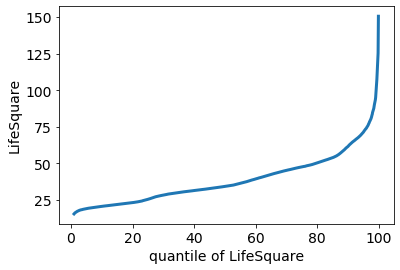

In [84]:
q = [np.percentile(data["LifeSquare"].dropna(), q=x) for x in np.arange(1, 100, 0.1)]
plt.plot(np.arange(1, 100, 0.1), q, linewidth=3)
plt.xlabel("quantile of LifeSquare", size=14)
plt.ylabel("LifeSquare", size=14)

**Healthcare_1 заполнение пропусков**

In [85]:
#довольно много пропусков

In [86]:
data["Healthcare_1"].isnull().sum()

7175

In [87]:
data['Healthcare_1'].describe()

count    7822.000000
mean     1144.373562
std      1029.403981
min         0.000000
25%       350.000000
50%       900.000000
75%      1548.000000
max      4849.000000
Name: Healthcare_1, dtype: float64

In [88]:
data['Healthcare_1'].value_counts()

540.0     768
30.0      510
1046.0    364
750.0     235
2300.0    220
         ... 
920.0      19
1815.0     19
32.0       19
35.0        4
0.0         2
Name: Healthcare_1, Length: 79, dtype: int64

In [89]:
data['Healthcare_1'].sort_values().unique()

array([   0.,   30.,   32.,   35.,   46.,   75.,   80.,  100.,  125.,
        145.,  165.,  176.,  192.,  200.,  229.,  240.,  262.,  320.,
        325.,  350.,  370.,  520.,  540.,  562.,  620.,  628.,  645.,
        705.,  730.,  750.,  770.,  800.,  810.,  830.,  900.,  920.,
        990., 1015., 1020., 1036., 1046., 1084., 1130., 1145., 1183.,
       1308., 1322., 1340., 1406., 1430., 1450., 1547., 1548., 1575.,
       1786., 1815., 1894., 1937., 1940., 1970., 1994., 2078., 2300.,
       2301., 2500., 2620., 2643., 2672., 2715., 2729., 2857., 2890.,
       3300., 3855., 4087., 4129., 4508., 4702., 4849.,   nan])

In [90]:
groupby = data.groupby(["DistrictId"])
stat = groupby["Healthcare_1"].apply(pd.Series.mode)
stat = dict({id_: value_ for id_, value_ in zip(np.sort(data["DistrictId"].unique()), stat.values)})

In [91]:
mask = data["Healthcare_1"].isnull()
data.loc[mask, "Healthcare_1"] = data.loc[mask, "DistrictId"].map(stat)

In [92]:
data.loc[data["Healthcare_1"].isnull()].sort_values(['DistrictId'])

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
9227,15676,182,3.0,49.934561,35.980287,3.0,9,8.0,1938,0.246624,B,B,14,2940,45,NaN,3,6,B,429090.881284
8505,12381,182,3.0,65.475260,44.184674,7.0,3,4.0,1918,0.246624,B,B,14,2940,45,NaN,3,6,B,540638.323555
7405,10529,182,3.0,45.378424,30.651801,6.0,5,4.0,1977,0.246624,B,B,14,2940,45,NaN,3,6,B,352139.644089
10852,4852,183,1.0,40.232007,22.404480,10.0,15,16.0,1978,0.246624,B,B,14,2940,45,NaN,3,6,B,NaN
13253,12316,183,2.0,157.976101,101.040485,12.0,7,8.0,1908,0.246624,B,B,14,2940,45,NaN,3,6,B,NaN
9825,15391,184,3.0,64.048840,42.844486,6.0,4,5.0,1928,0.246624,B,B,14,2940,45,NaN,3,6,B,324303.812481
11634,4273,184,4.0,80.992528,53.191788,7.0,4,4.0,1956,0.246624,B,B,14,2940,45,NaN,3,6,B,NaN
8760,2627,184,2.0,59.374842,37.005193,7.0,4,5.0,1960,0.246624,B,B,14,2940,45,NaN,3,6,B,287959.519851
11991,15208,184,3.0,126.473035,125.473035,1.0,8,6.0,2014,0.246624,B,B,14,2940,45,NaN,3,6,B,NaN
7049,8825,184,2.0,56.867381,38.917371,7.0,5,8.0,1963,0.246624,B,B,14,2940,45,NaN,3,6,B,278718.568188


In [93]:
data["Healthcare_1"].isnull().sum()

51

In [94]:
data.loc[data["Healthcare_1"].isnull(), 'Healthcare_1'] = data['Healthcare_1'].median()

In [95]:
data["Healthcare_1"].isnull().sum()

0

**HouseYear**

In [96]:
data['HouseYear'].sort_values().unique()

array([    1908,     1909,     1910,     1911,     1912,     1914,
           1916,     1917,     1918,     1919,     1920,     1926,
           1927,     1928,     1929,     1930,     1931,     1932,
           1933,     1934,     1935,     1936,     1937,     1938,
           1939,     1940,     1941,     1942,     1943,     1947,
           1948,     1949,     1950,     1951,     1952,     1953,
           1954,     1955,     1956,     1957,     1958,     1959,
           1960,     1961,     1962,     1963,     1964,     1965,
           1966,     1967,     1968,     1969,     1970,     1971,
           1972,     1973,     1974,     1975,     1976,     1977,
           1978,     1979,     1980,     1981,     1982,     1983,
           1984,     1985,     1986,     1987,     1988,     1989,
           1990,     1991,     1992,     1993,     1994,     1995,
           1996,     1997,     1998,     1999,     2000,     2001,
           2002,     2003,     2004,     2005,     2006,     2

In [97]:
data.loc[data['HouseYear'] == 20052011, 'HouseYear'] = 2011

In [98]:
data.loc[data['HouseYear'] == 4968, 'HouseYear'] = data['HouseYear'].median()

In [99]:
data['HouseYear'].sort_values().unique()

array([1908., 1909., 1910., 1911., 1912., 1914., 1916., 1917., 1918.,
       1919., 1920., 1926., 1927., 1928., 1929., 1930., 1931., 1932.,
       1933., 1934., 1935., 1936., 1937., 1938., 1939., 1940., 1941.,
       1942., 1943., 1947., 1948., 1949., 1950., 1951., 1952., 1953.,
       1954., 1955., 1956., 1957., 1958., 1959., 1960., 1961., 1962.,
       1963., 1964., 1965., 1966., 1967., 1968., 1969., 1970., 1971.,
       1972., 1973., 1974., 1975., 1976., 1977., 1978., 1979., 1980.,
       1981., 1982., 1983., 1984., 1985., 1986., 1987., 1988., 1989.,
       1990., 1991., 1992., 1993., 1994., 1995., 1996., 1997., 1998.,
       1999., 2000., 2001., 2002., 2003., 2004., 2005., 2006., 2007.,
       2008., 2009., 2010., 2011., 2012., 2013., 2014., 2015., 2016.,
       2017., 2018., 2019., 2020.])

In [100]:
data['HouseAge'] = 2020 - data['HouseYear']

In [101]:
data.head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,...,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price,HouseAge
0,14038,35,2.0,47.981561,29.442751,6.0,7,9.0,1969.0,0.089040,...,B,33,7976,5,1145.0,0,11,B,184966.930730,51.0
1,15053,41,3.0,65.683640,40.049543,8.0,7,9.0,1978.0,0.000070,...,B,46,10309,1,240.0,1,16,B,300009.450063,42.0
2,4765,53,2.0,44.947953,29.197612,1.0,8,12.0,1968.0,0.049637,...,B,34,7759,0,229.0,1,3,B,220925.908524,52.0
3,5809,58,2.0,53.352981,44.352981,9.0,8,17.0,1977.0,0.437885,...,B,23,5735,3,1084.0,0,5,B,175616.227217,43.0
4,10783,99,1.0,39.649192,23.776169,7.0,11,12.0,1976.0,0.012339,...,B,35,5776,1,2078.0,2,4,B,150226.531644,44.0


**Floor**

In [102]:
data.describe()

,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Price,HouseAge
count,14997.000000,14997.000000,14997.000000,14997.000000,14997.000000,14997.000000,14997.000000,14997.000000,14997.000000,14997.000000,14997.000000,14997.000000,14997.000000,14997.000000,14997.000000,9997.000000,14997.000000
mean,50.694339,1.889378,56.393691,38.571822,5.784290,8.560779,12.606388,1984.705141,0.119193,24.769354,5370.416683,8.105421,1192.464226,1.319197,4.233780,214161.934244,35.294859
std,43.786983,0.799418,19.191713,17.643983,3.871478,5.322250,6.780135,18.464235,0.119375,17.534014,4013.738184,23.819546,949.999743,1.489024,4.794555,92874.114626,18.464235
min,0.000000,1.000000,1.378543,0.378543,1.000000,1.000000,0.000000,1908.000000,0.000000,0.000000,168.000000,0.000000,0.000000,0.000000,0.000000,59174.778028,0.000000
25%,20.000000,1.000000,41.926542,25.338900,1.000000,4.000000,9.000000,1974.000000,0.017647,6.000000,1564.000000,0.000000,540.000000,0.000000,1.000000,153893.979077,19.000000
50%,37.000000,2.000000,52.799556,34.172460,6.000000,7.000000,12.000000,1977.000000,0.075424,25.000000,5285.000000,2.000000,1015.000000,1.000000,3.000000,192302.751941,43.000000
75%,75.000000,2.000000,66.153623,47.501039,9.000000,12.000000,17.000000,2001.000000,0.195781,36.000000,7287.000000,5.000000,1786.000000,2.000000,6.000000,249174.529858,46.000000
max,212.000000,4.000000,275.645284,233.949309,42.000000,78.000000,117.000000,2020.000000,0.521867,74.000000,19083.000000,141.000000,4849.000000,6.000000,23.000000,633233.466570,112.000000


In [103]:
data['HouseFloor'].sort_values().unique()

array([  0.,   1.,   2.,   3.,   4.,   5.,   6.,   7.,   8.,   9.,  10.,
        11.,  12.,  13.,  14.,  15.,  16.,  17.,  18.,  19.,  20.,  21.,
        22.,  23.,  24.,  25.,  26.,  27.,  28.,  29.,  30.,  31.,  32.,
        33.,  34.,  36.,  37.,  38.,  39.,  40.,  44.,  45.,  47.,  48.,
        99., 117.])

In [104]:
data['HouseFloor'].value_counts()

17.0     3482
9.0      2113
12.0     1600
5.0      1581
14.0      969
16.0      811
1.0       727
25.0      553
22.0      536
0.0       400
24.0      274
8.0       213
10.0      199
3.0       196
4.0       191
15.0      172
19.0      158
20.0      153
18.0      132
6.0        93
7.0        87
2.0        74
23.0       62
21.0       42
13.0       40
11.0       39
30.0       26
40.0       16
27.0       11
37.0        6
32.0        6
48.0        5
28.0        5
26.0        5
39.0        4
99.0        3
29.0        2
31.0        2
36.0        2
33.0        1
117.0       1
38.0        1
44.0        1
45.0        1
34.0        1
47.0        1
Name: HouseFloor, dtype: int64

In [105]:
data.loc[data['HouseFloor']>99, 'HouseFloor'] = data['HouseFloor'].median()

In [106]:
data['HouseFloor'].median()

12.0

In [107]:
data['Floor'].sort_values().unique()

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 31, 32, 33, 34, 37, 38,
       42, 46, 78])

In [108]:
data.loc[data['Floor'] == 78]

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,...,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price,HouseAge
14698,15759,17,2.0,57.60187,37.744743,10.0,78,22.0,1989.0,0.0,...,B,25,5027,4,46.0,1,1,B,NaN,31.0


In [109]:
data.loc[data['HouseFloor'] == 0, 'HouseFloor'] = data['HouseFloor'].median()

In [110]:
floor_outliers = data[data['Floor'] > data['HouseFloor']].index

data.loc[floor_outliers, 'Floor'] = data.loc[floor_outliers, 'HouseFloor'].apply(
    lambda x: random.randint(1, x)
)

In [111]:
data[data['Floor'] > data['HouseFloor']]

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,...,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price,HouseAge


In [112]:
data.describe()

,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Price,HouseAge
count,14997.000000,14997.000000,14997.000000,14997.000000,14997.000000,14997.000000,14997.000000,14997.000000,14997.000000,14997.000000,14997.000000,14997.000000,14997.000000,14997.000000,14997.000000,9997.000000,14997.000000
mean,50.694339,1.889378,56.393691,38.571822,5.784290,7.427619,12.919451,1984.705141,0.119193,24.769354,5370.416683,8.105421,1192.464226,1.319197,4.233780,214161.934244,35.294859
std,43.786983,0.799418,19.191713,17.643983,3.871478,5.070132,6.396584,18.464235,0.119375,17.534014,4013.738184,23.819546,949.999743,1.489024,4.794555,92874.114626,18.464235
min,0.000000,1.000000,1.378543,0.378543,1.000000,1.000000,1.000000,1908.000000,0.000000,0.000000,168.000000,0.000000,0.000000,0.000000,0.000000,59174.778028,0.000000
25%,20.000000,1.000000,41.926542,25.338900,1.000000,3.000000,9.000000,1974.000000,0.017647,6.000000,1564.000000,0.000000,540.000000,0.000000,1.000000,153893.979077,19.000000
50%,37.000000,2.000000,52.799556,34.172460,6.000000,6.000000,12.000000,1977.000000,0.075424,25.000000,5285.000000,2.000000,1015.000000,1.000000,3.000000,192302.751941,43.000000
75%,75.000000,2.000000,66.153623,47.501039,9.000000,11.000000,17.000000,2001.000000,0.195781,36.000000,7287.000000,5.000000,1786.000000,2.000000,6.000000,249174.529858,46.000000
max,212.000000,4.000000,275.645284,233.949309,42.000000,46.000000,99.000000,2020.000000,0.521867,74.000000,19083.000000,141.000000,4849.000000,6.000000,23.000000,633233.466570,112.000000


In [113]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 14997 entries, 0 to 14999
Data columns (total 21 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             14997 non-null  object 
 1   DistrictId     14997 non-null  int64  
 2   Rooms          14997 non-null  float64
 3   Square         14997 non-null  float64
 4   LifeSquare     14997 non-null  float64
 5   KitchenSquare  14997 non-null  float64
 6   Floor          14997 non-null  int64  
 7   HouseFloor     14997 non-null  float64
 8   HouseYear      14997 non-null  float64
 9   Ecology_1      14997 non-null  float64
 10  Ecology_2      14997 non-null  object 
 11  Ecology_3      14997 non-null  object 
 12  Social_1       14997 non-null  int64  
 13  Social_2       14997 non-null  int64  
 14  Social_3       14997 non-null  int64  
 15  Healthcare_1   14997 non-null  float64
 16  Helthcare_2    14997 non-null  int64  
 17  Shops_1        14997 non-null  int64  
 18  Shops_

In [114]:
data['Ecology_1'].value_counts()

0.007122    884
0.000000    816
0.243205    768
0.072158    714
0.075779    501
           ... 
0.059456      4
0.394094      4
0.014334      2
0.012522      1
0.005819      1
Name: Ecology_1, Length: 131, dtype: int64

In [115]:
data.loc[(data["Ecology_1"] == 0)]

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,...,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price,HouseAge
11,12427,31,3.0,68.808859,45.736906,7.0,1,8.0,1959.0,0.0,...,B,23,3684,2,1994.0,0,4,B,165534.541425,61.0
35,6486,200,3.0,85.280389,58.447967,9.0,4,5.0,1960.0,0.0,...,B,33,7425,1,1015.0,2,5,B,402871.916317,60.0
38,8224,177,3.0,77.873936,48.991133,12.0,9,25.0,2012.0,0.0,...,B,36,6714,2,2672.0,0,2,B,191550.121357,8.0
80,15600,108,2.0,49.888740,31.603650,6.0,9,12.0,1974.0,0.0,...,B,23,3684,2,1450.0,0,4,B,261086.024406,46.0
83,2855,18,2.0,61.718553,33.040115,10.0,10,11.0,2000.0,0.0,...,B,30,5562,0,1183.0,0,5,A,267609.827251,20.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14835,11907,17,1.0,42.966641,19.444965,9.0,2,8.0,1960.0,0.0,...,B,25,5027,4,46.0,1,1,B,NaN,60.0
14871,3945,128,2.0,47.873633,27.229154,6.0,8,9.0,1972.0,0.0,...,B,27,4798,0,30.0,2,8,B,NaN,48.0
14876,6671,145,2.0,52.925044,30.100027,8.0,2,17.0,1988.0,0.0,...,B,30,5562,0,176.0,0,5,A,NaN,32.0
14923,4891,18,3.0,63.248069,41.882735,7.0,9,14.0,1987.0,0.0,...,B,30,5562,0,1183.0,0,5,A,NaN,33.0


In [116]:
data['Ecology_2'].value_counts()

B    14852
A      145
Name: Ecology_2, dtype: int64

In [117]:
data['Ecology_3'].value_counts()

B    14573
A      424
Name: Ecology_3, dtype: int64

In [118]:
data["Eco2_Eco3"] = data.Ecology_2 + data.Ecology_3

In [119]:
data['Eco2_Eco3'].value_counts()

BB    14428
BA      424
AB      145
Name: Eco2_Eco3, dtype: int64

In [120]:
pd.get_dummies(data['Eco2_Eco3'], prefix=['Eco2_Eco3'])

,['Eco2_Eco3']_AB,['Eco2_Eco3']_BA,['Eco2_Eco3']_BB
0,0,0,1
1,0,0,1
2,0,0,1
3,0,0,1
4,0,0,1
...,...,...,...
14995,0,0,1
14996,0,0,1
14997,0,0,1
14998,0,0,1


In [121]:
data = pd.concat([data, pd.get_dummies(data['Eco2_Eco3'], prefix=['Eco2_Eco3'])], axis=1)

data.head(n=5)

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,...,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price,HouseAge,Eco2_Eco3,['Eco2_Eco3']_AB,['Eco2_Eco3']_BA,['Eco2_Eco3']_BB
0,14038,35,2.0,47.981561,29.442751,6.0,7,9.0,1969.0,0.089040,...,1145.0,0,11,B,184966.930730,51.0,BB,0,0,1
1,15053,41,3.0,65.683640,40.049543,8.0,7,9.0,1978.0,0.000070,...,240.0,1,16,B,300009.450063,42.0,BB,0,0,1
2,4765,53,2.0,44.947953,29.197612,1.0,8,12.0,1968.0,0.049637,...,229.0,1,3,B,220925.908524,52.0,BB,0,0,1
3,5809,58,2.0,53.352981,44.352981,9.0,8,17.0,1977.0,0.437885,...,1084.0,0,5,B,175616.227217,43.0,BB,0,0,1
4,10783,99,1.0,39.649192,23.776169,7.0,11,12.0,1976.0,0.012339,...,2078.0,2,4,B,150226.531644,44.0,BB,0,0,1


In [122]:
data['Social_1'].value_counts()

2     1001
1      995
5      796
25     794
30     704
23     654
22     558
53     550
6      543
34     455
33     391
31     386
46     377
43     374
37     319
24     309
21     308
9      307
52     303
0      301
35     298
36     297
47     265
74     265
39     240
27     227
11     216
28     210
4      207
16     188
42     182
19     174
26     172
18     150
17     148
49     144
32     142
66     142
41     122
50     112
29     108
38     106
8       92
15      72
14      71
20      71
10      35
13      34
7       32
12      32
3       18
Name: Social_1, dtype: int64

In [123]:
data['Social_1'].sort_values().unique()

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
       34, 35, 36, 37, 38, 39, 41, 42, 43, 46, 47, 49, 50, 52, 53, 66, 74])

In [124]:
data['Social_2'].sort_values().unique()

array([  168,   186,   264,   290,   342,   362,   388,   469,   475,
         507,   528,   568,   629,   662,   760,   915,  1135,  1227,
        1318,  1423,  1437,  1497,  1564,  1660,  1768,  1892,  1952,
        1986,  2270,  2277,  2370,  2398,  2423,  2514,  2733,  2738,
        2748,  2787,  2810,  2940,  3079,  3097,  3151,  3293,  3369,
        3374,  3379,  3433,  3478,  3594,  3681,  3684,  3746,  3806,
        3856,  3889,  3893,  3975,  4017,  4048,  4231,  4346,  4378,
        4386,  4439,  4472,  4583,  4625,  4635,  4724,  4756,  4788,
        4789,  4798,  4860,  5011,  5027,  5048,  5067,  5148,  5212,
        5261,  5285,  5288,  5469,  5487,  5562,  5569,  5613,  5648,
        5664,  5731,  5735,  5776,  5889,  5992,  6119,  6137,  6141,
        6149,  6207,  6398,  6533,  6558,  6564,  6566,  6714,  6746,
        6748,  6783,  6856,  7010,  7065,  7077,  7227,  7287,  7425,
        7538,  7614,  7651,  7687,  7715,  7759,  7960,  7976,  8004,
        8429,  8647,

In [125]:
data['Social_2'].value_counts()

264     884
1564    768
629     714
1437    501
6398    364
       ... 
568       4
362       4
528       2
507       1
342       1
Name: Social_2, Length: 144, dtype: int64

In [126]:
data['Social_3'].sort_values().unique()

array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  14,
        16,  19,  20,  23,  24,  27,  37,  39,  45,  48,  56,  59,  73,
        84,  87,  93, 141])

In [127]:
data['Social_3'].value_counts()

0      4467
1      2756
3      1676
4      1279
2       958
6       636
5       592
141     364
9       308
7       276
11      268
8       247
10      227
14      150
16      147
48       94
27       81
84       75
56       68
24       57
93       37
87       37
59       36
19       34
39       32
23       32
20       25
73       19
45       14
37        5
Name: Social_3, dtype: int64

In [128]:
data['Helthcare_2'].sort_values().unique()

array([0, 1, 2, 3, 4, 5, 6])

In [129]:
data['Helthcare_2'].value_counts()

0    6310
1    3279
3    2523
2    1727
5     574
4     446
6     138
Name: Helthcare_2, dtype: int64

In [130]:
data['Shops_1'].sort_values().unique()

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 15, 16, 19, 23])

In [131]:
data['Shops_1'].value_counts()

0     3466
5     1993
1     1976
2     1448
4     1253
3     1079
6      730
11     625
9      476
7      442
23     364
8      358
10     332
15     265
16     122
19      68
Name: Shops_1, dtype: int64

In [132]:
data['Shops_2'].sort_values().unique()

array(['A', 'B'], dtype=object)

In [133]:
data['Shops_2_bin'] = data['Shops_2'].replace({'A':0, 'B':1})

In [134]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 14997 entries, 0 to 14999
Data columns (total 26 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Id                14997 non-null  object 
 1   DistrictId        14997 non-null  int64  
 2   Rooms             14997 non-null  float64
 3   Square            14997 non-null  float64
 4   LifeSquare        14997 non-null  float64
 5   KitchenSquare     14997 non-null  float64
 6   Floor             14997 non-null  int64  
 7   HouseFloor        14997 non-null  float64
 8   HouseYear         14997 non-null  float64
 9   Ecology_1         14997 non-null  float64
 10  Ecology_2         14997 non-null  object 
 11  Ecology_3         14997 non-null  object 
 12  Social_1          14997 non-null  int64  
 13  Social_2          14997 non-null  int64  
 14  Social_3          14997 non-null  int64  
 15  Healthcare_1      14997 non-null  float64
 16  Helthcare_2       14997 non-null  int64 

In [135]:
import matplotlib
import matplotlib.image as img
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [136]:
data['DistrictId'] = data['DistrictId'].astype(str)
data['DistrictId'].dtype

dtype('O')

In [137]:
x_train = data[data["Price"].notnull()]
x_test = data[data["Price"].isnull()]

In [138]:
x_train_num_features = x_train.select_dtypes(include=['float64', 'int64'])
x_train_num_features

,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Price,HouseAge,Shops_2_bin
0,2.0,47.981561,29.442751,6.0,7,9.0,1969.0,0.089040,33,7976,5,1145.0,0,11,184966.930730,51.0,1
1,3.0,65.683640,40.049543,8.0,7,9.0,1978.0,0.000070,46,10309,1,240.0,1,16,300009.450063,42.0,1
2,2.0,44.947953,29.197612,1.0,8,12.0,1968.0,0.049637,34,7759,0,229.0,1,3,220925.908524,52.0,1
3,2.0,53.352981,44.352981,9.0,8,17.0,1977.0,0.437885,23,5735,3,1084.0,0,5,175616.227217,43.0,1
4,1.0,39.649192,23.776169,7.0,11,12.0,1976.0,0.012339,35,5776,1,2078.0,2,4,150226.531644,44.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,2.0,50.401785,30.476203,5.0,3,5.0,1968.0,0.135650,46,7960,6,350.0,3,11,196684.316040,52.0,1
9996,1.0,41.521546,20.539216,9.0,13,13.0,2000.0,0.000000,30,5562,0,1183.0,0,5,189050.289571,20.0,0
9997,1.0,47.939008,35.183855,1.0,12,16.0,2015.0,0.072158,2,629,1,800.0,0,0,159143.805370,5.0,0
9998,2.0,43.602562,33.840147,8.0,1,5.0,1961.0,0.307467,30,5048,9,325.0,2,5,181595.339808,59.0,1


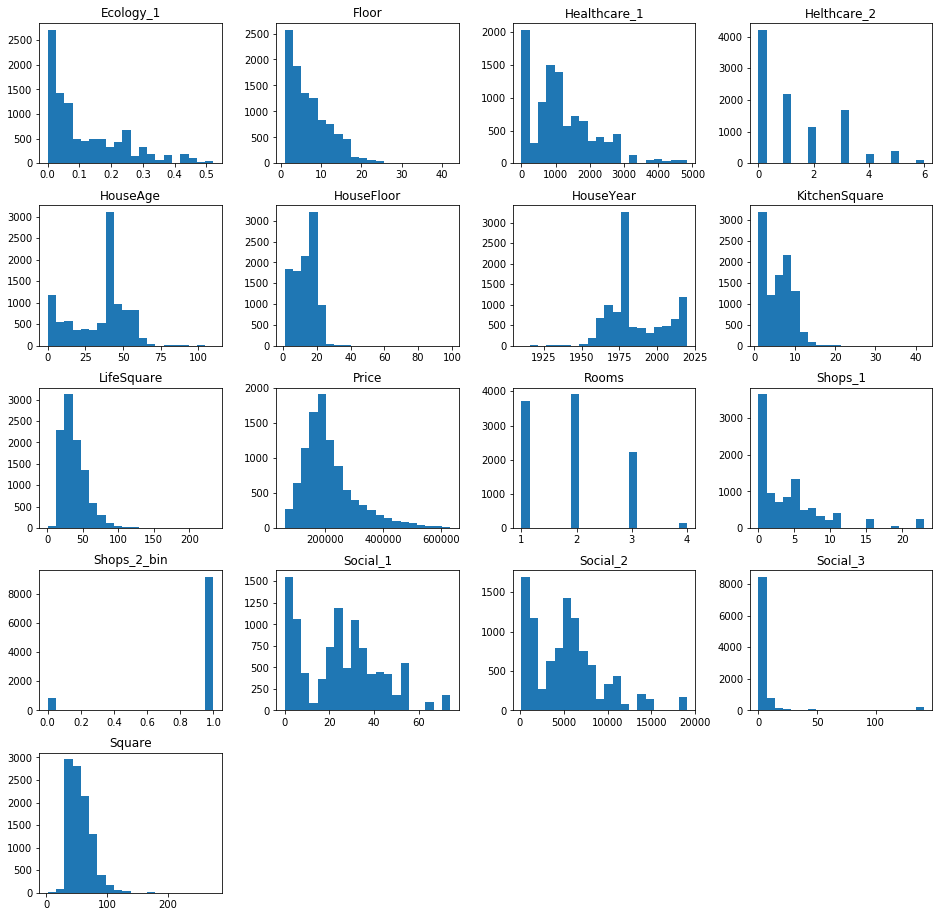

In [139]:
x_train_num_features.hist(figsize=(16,16), bins=20, grid=False);


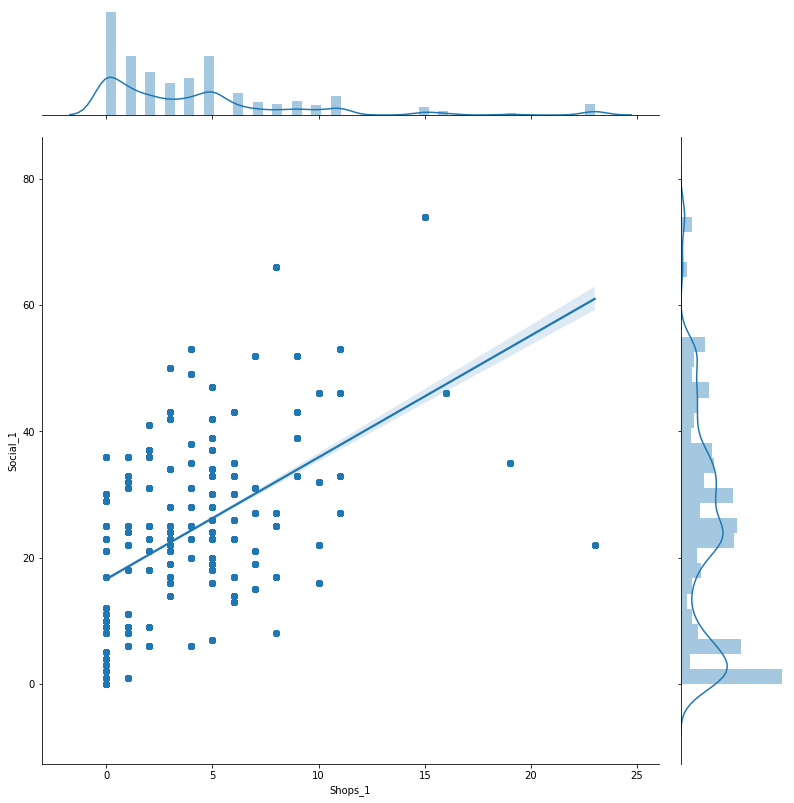

In [140]:
grid = sns.jointplot(data['Shops_1'], data['Social_1'], kind='reg')
grid.fig.set_figwidth(12)
grid.fig.set_figheight(12)

plt.show()

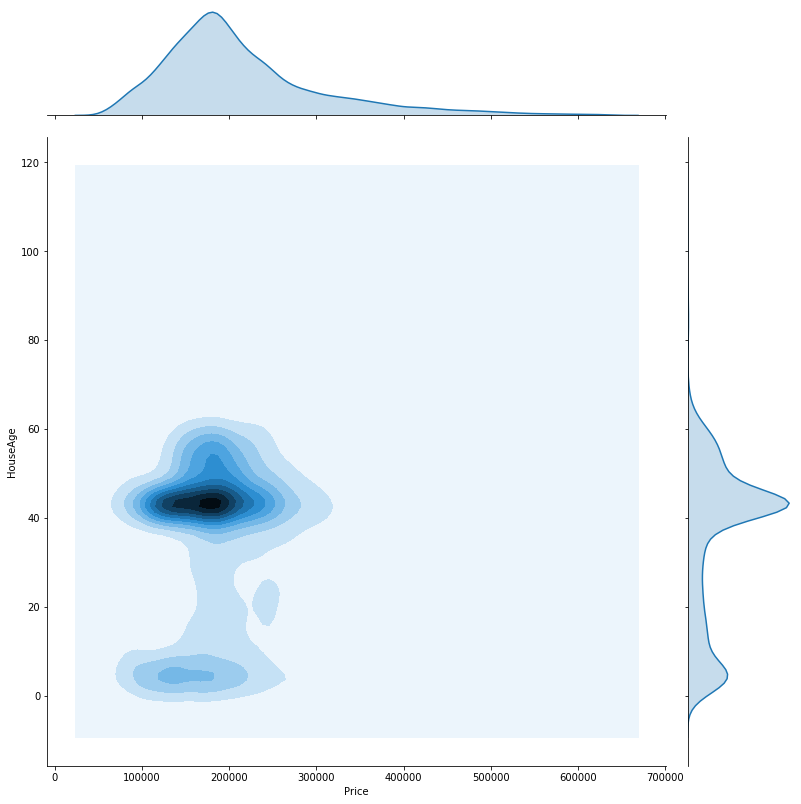

In [141]:
grid = sns.jointplot(x_train['Price'], x_train['HouseAge'], logx=True, logy=True, kind='kde')
grid.fig.set_figwidth(12)
grid.fig.set_figheight(12)


plt.show()

### Матрица корреляций

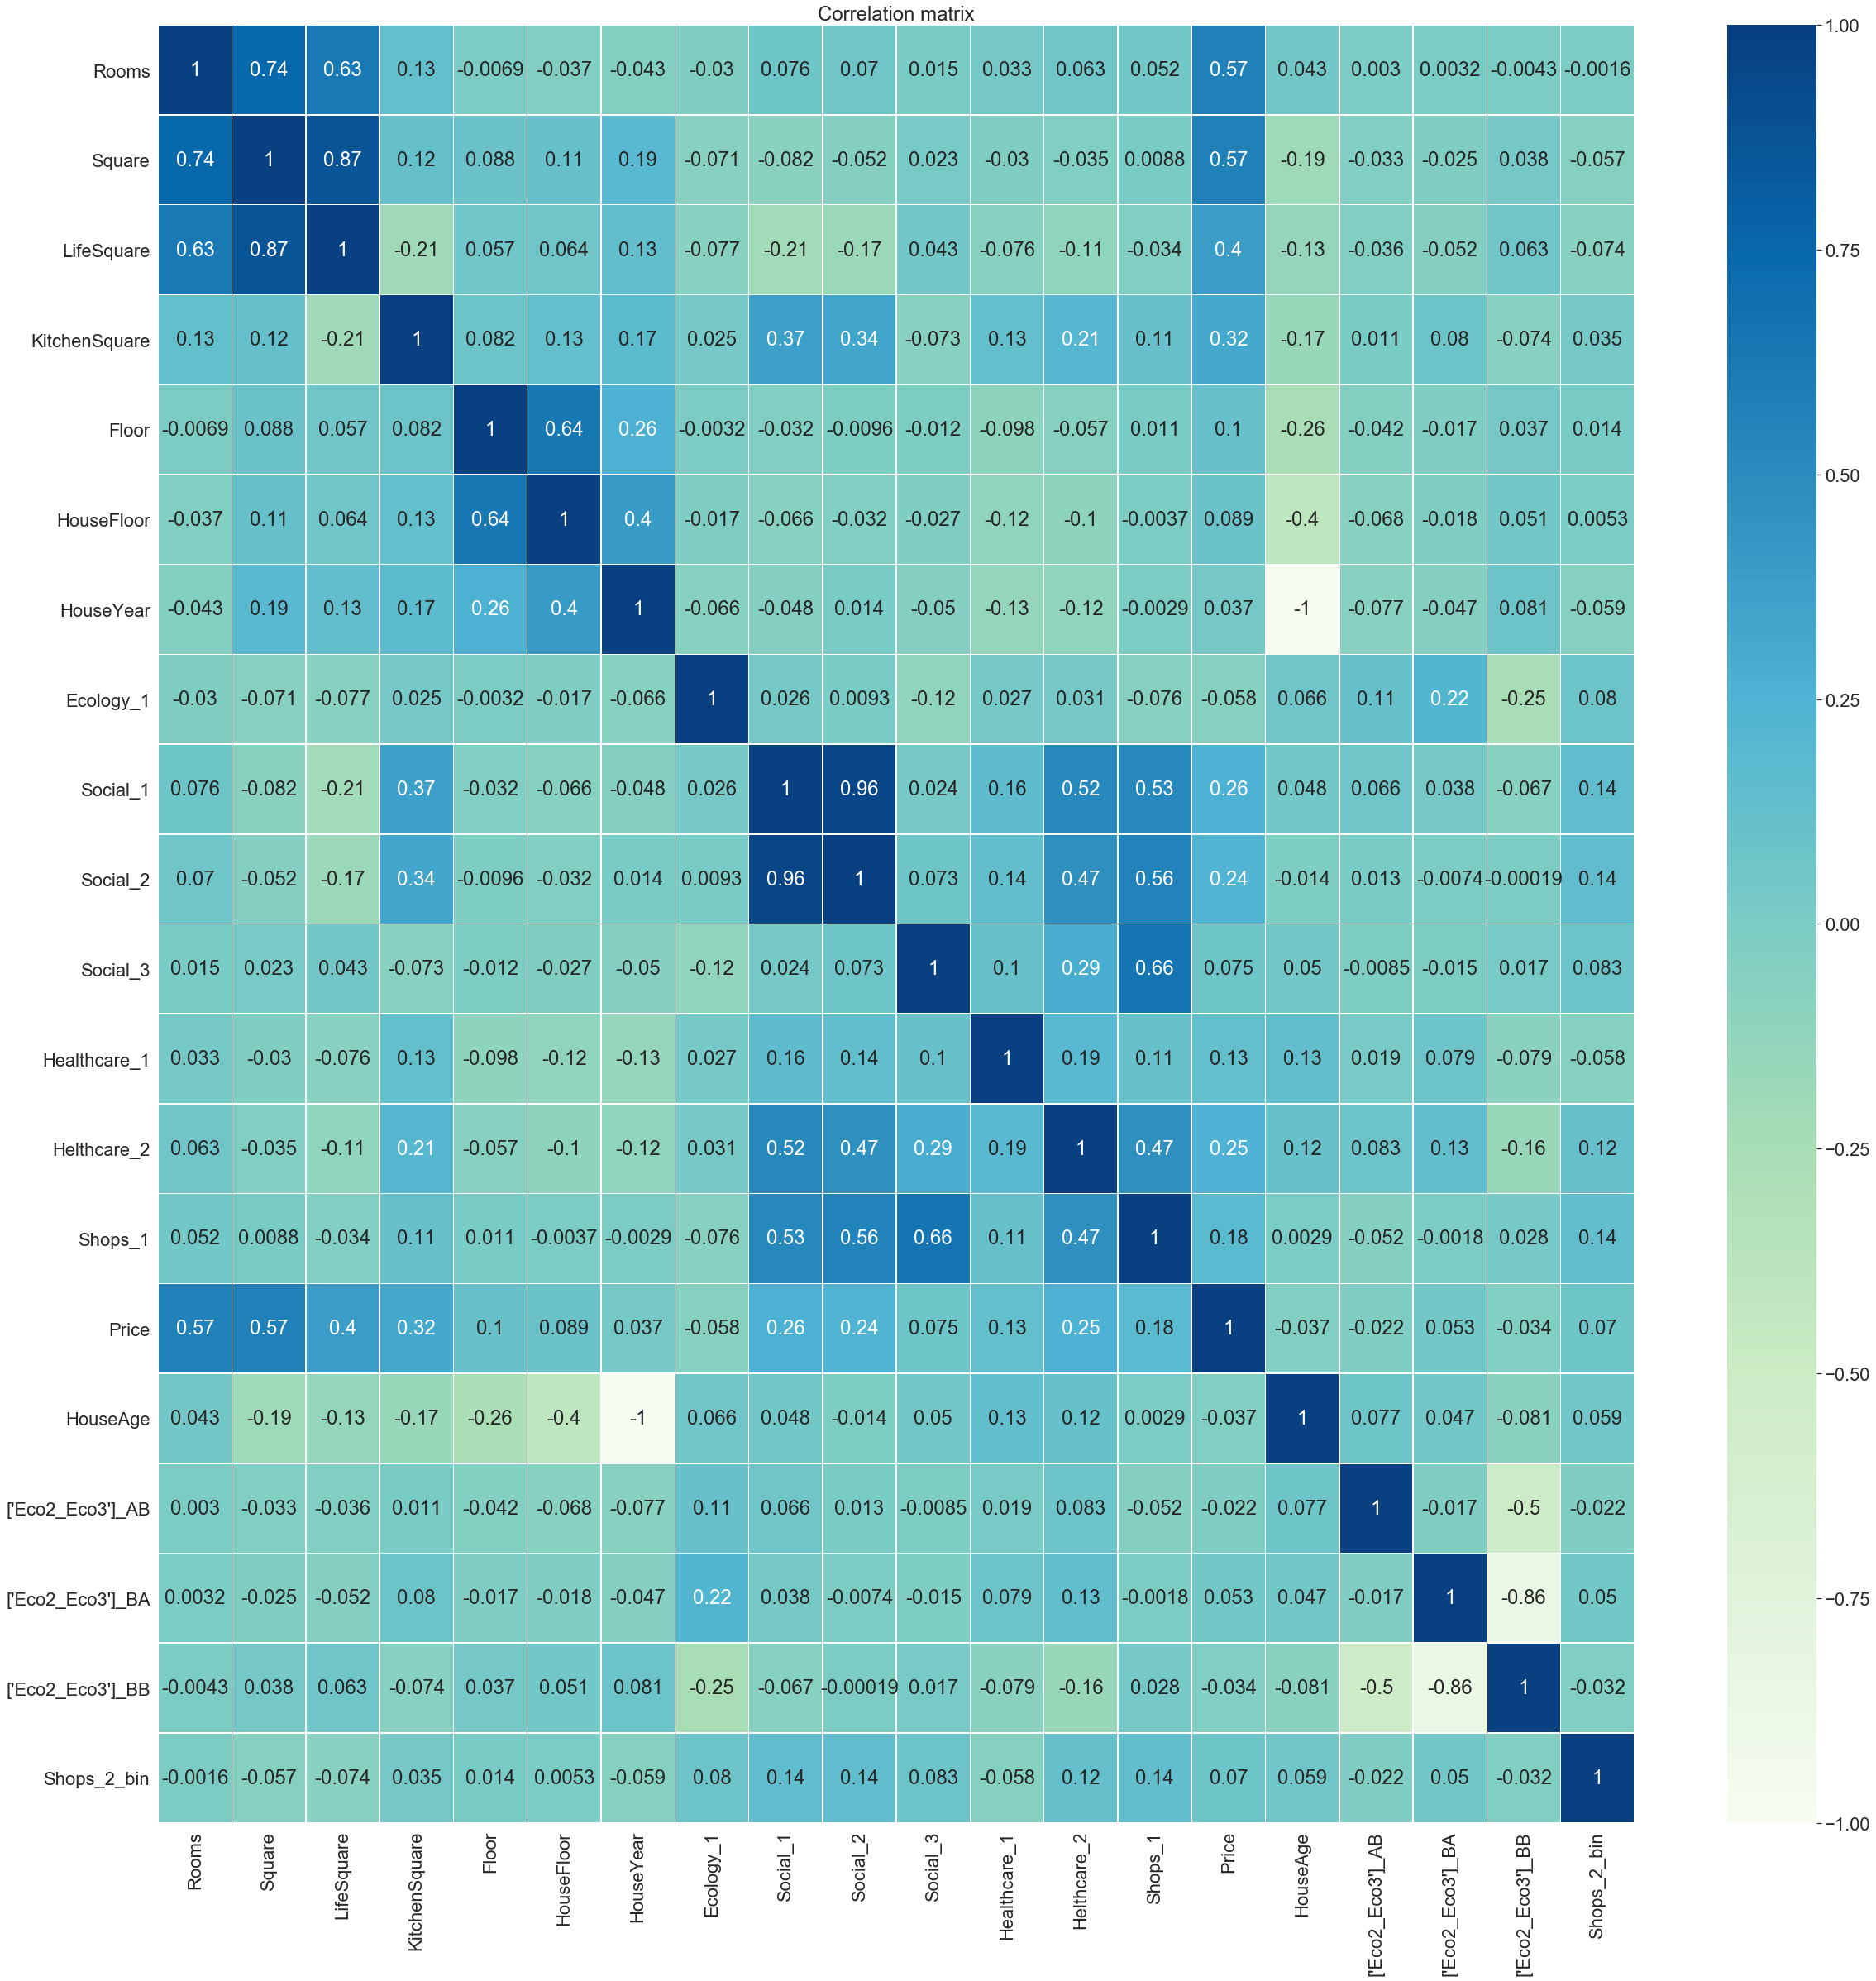

In [142]:

plt.figure(figsize = (40,40))

sns.set(font_scale=2)
sns.heatmap(x_train.corr(), annot=True, linewidths=.5, cmap='GnBu')

plt.title('Correlation matrix')
plt.show()

### Построение новых признаков

* Признаки на основе группировок: по одному полю или по нескольим полям
* Разность между признаком и сгруппированной статистикой
* Бинарные флаги
* Признаки на основе целевой переменной (__Будь осторожен__)
* Frequency Transformer

In [143]:
gp = data.groupby(["Rooms"])["Square"].mean()
data["Mean_Square_by_rooms"] = data["Rooms"].map(gp.to_dict())

data["diff_square_and_mean_square_by_rooms"] = data["Square"] - data["Mean_Square_by_rooms"]
data["ratio_square_and_mean_square_by_rooms"] = data["Square"] / data["Mean_Square_by_rooms"] - 1

In [144]:
data["bigger_then_mean"] = np.where(
    data["diff_square_and_mean_square_by_rooms"] > 0, 1, 0)

In [145]:
data.head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,...,HouseAge,Eco2_Eco3,['Eco2_Eco3']_AB,['Eco2_Eco3']_BA,['Eco2_Eco3']_BB,Shops_2_bin,Mean_Square_by_rooms,diff_square_and_mean_square_by_rooms,ratio_square_and_mean_square_by_rooms,bigger_then_mean
0,14038,35,2.0,47.981561,29.442751,6.0,7,9.0,1969.0,0.089040,...,51.0,BB,0,0,1,1,57.015011,-9.033449,-0.158440,0
1,15053,41,3.0,65.683640,40.049543,8.0,7,9.0,1978.0,0.000070,...,42.0,BB,0,0,1,1,77.078618,-11.394978,-0.147836,0
2,4765,53,2.0,44.947953,29.197612,1.0,8,12.0,1968.0,0.049637,...,52.0,BB,0,0,1,1,57.015011,-12.067058,-0.211647,0
3,5809,58,2.0,53.352981,44.352981,9.0,8,17.0,1977.0,0.437885,...,43.0,BB,0,0,1,1,57.015011,-3.662029,-0.064229,0
4,10783,99,1.0,39.649192,23.776169,7.0,11,12.0,1976.0,0.012339,...,44.0,BB,0,0,1,1,41.314931,-1.665739,-0.040318,0


In [146]:
# Добавление признака размер района:
district_size = data['DistrictId'].value_counts().reset_index()\
               .rename(columns={'index':'DistrictId', 'DistrictId':'DistrictSize'})

district_size.head()   

,DistrictId,DistrictSize
0,27,1242
1,1,996
2,23,829
3,6,768
4,9,425


In [147]:
data = data.merge(district_size, on='DistrictId', how='left')
data.head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,...,Eco2_Eco3,['Eco2_Eco3']_AB,['Eco2_Eco3']_BA,['Eco2_Eco3']_BB,Shops_2_bin,Mean_Square_by_rooms,diff_square_and_mean_square_by_rooms,ratio_square_and_mean_square_by_rooms,bigger_then_mean,DistrictSize
0,14038,35,2.0,47.981561,29.442751,6.0,7,9.0,1969.0,0.089040,...,BB,0,0,1,1,57.015011,-9.033449,-0.158440,0,36
1,15053,41,3.0,65.683640,40.049543,8.0,7,9.0,1978.0,0.000070,...,BB,0,0,1,1,77.078618,-11.394978,-0.147836,0,131
2,4765,53,2.0,44.947953,29.197612,1.0,8,12.0,1968.0,0.049637,...,BB,0,0,1,1,57.015011,-12.067058,-0.211647,0,265
3,5809,58,2.0,53.352981,44.352981,9.0,8,17.0,1977.0,0.437885,...,BB,0,0,1,1,57.015011,-3.662029,-0.064229,0,270
4,10783,99,1.0,39.649192,23.776169,7.0,11,12.0,1976.0,0.012339,...,BB,0,0,1,1,41.314931,-1.665739,-0.040318,0,139


In [148]:
(data['DistrictSize'] > 100).value_counts()

True     10146
False     4851
Name: DistrictSize, dtype: int64

In [149]:
data['IsDistrictLarge'] = (data['DistrictSize'] > 100).astype(int)

In [150]:
data.head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,...,['Eco2_Eco3']_AB,['Eco2_Eco3']_BA,['Eco2_Eco3']_BB,Shops_2_bin,Mean_Square_by_rooms,diff_square_and_mean_square_by_rooms,ratio_square_and_mean_square_by_rooms,bigger_then_mean,DistrictSize,IsDistrictLarge
0,14038,35,2.0,47.981561,29.442751,6.0,7,9.0,1969.0,0.089040,...,0,0,1,1,57.015011,-9.033449,-0.158440,0,36,0
1,15053,41,3.0,65.683640,40.049543,8.0,7,9.0,1978.0,0.000070,...,0,0,1,1,77.078618,-11.394978,-0.147836,0,131,1
2,4765,53,2.0,44.947953,29.197612,1.0,8,12.0,1968.0,0.049637,...,0,0,1,1,57.015011,-12.067058,-0.211647,0,265,1
3,5809,58,2.0,53.352981,44.352981,9.0,8,17.0,1977.0,0.437885,...,0,0,1,1,57.015011,-3.662029,-0.064229,0,270,1
4,10783,99,1.0,39.649192,23.776169,7.0,11,12.0,1976.0,0.012339,...,0,0,1,1,41.314931,-1.665739,-0.040318,0,139,1


In [151]:
# MedPriceByDistrict считаем только по трайн
med_price_by_district = x_train.groupby(['DistrictId', 'Rooms'], as_index=False).agg({'Price':'median'})\
                       .rename(columns={'Price':'MedPriceByDistrict'})

med_price_by_district.head()

,DistrictId,Rooms,MedPriceByDistrict
0,0,1.0,142799.434052
1,0,2.0,176210.812334
2,0,3.0,300610.359425
3,1,1.0,146735.671740
4,1,2.0,202666.310126


In [152]:
data = data.merge(med_price_by_district, on=['DistrictId', 'Rooms'], how='left')
data.head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,...,['Eco2_Eco3']_BA,['Eco2_Eco3']_BB,Shops_2_bin,Mean_Square_by_rooms,diff_square_and_mean_square_by_rooms,ratio_square_and_mean_square_by_rooms,bigger_then_mean,DistrictSize,IsDistrictLarge,MedPriceByDistrict
0,14038,35,2.0,47.981561,29.442751,6.0,7,9.0,1969.0,0.089040,...,0,1,1,57.015011,-9.033449,-0.158440,0,36,0,207786.135836
1,15053,41,3.0,65.683640,40.049543,8.0,7,9.0,1978.0,0.000070,...,0,1,1,77.078618,-11.394978,-0.147836,0,131,1,300009.450063
2,4765,53,2.0,44.947953,29.197612,1.0,8,12.0,1968.0,0.049637,...,0,1,1,57.015011,-12.067058,-0.211647,0,265,1,262760.660265
3,5809,58,2.0,53.352981,44.352981,9.0,8,17.0,1977.0,0.437885,...,0,1,1,57.015011,-3.662029,-0.064229,0,270,1,166809.665642
4,10783,99,1.0,39.649192,23.776169,7.0,11,12.0,1976.0,0.012339,...,0,1,1,41.314931,-1.665739,-0.040318,0,139,1,158539.052715


In [153]:
data.columns.tolist()

['Id',
 'DistrictId',
 'Rooms',
 'Square',
 'LifeSquare',
 'KitchenSquare',
 'Floor',
 'HouseFloor',
 'HouseYear',
 'Ecology_1',
 'Ecology_2',
 'Ecology_3',
 'Social_1',
 'Social_2',
 'Social_3',
 'Healthcare_1',
 'Helthcare_2',
 'Shops_1',
 'Shops_2',
 'Price',
 'HouseAge',
 'Eco2_Eco3',
 "['Eco2_Eco3']_AB",
 "['Eco2_Eco3']_BA",
 "['Eco2_Eco3']_BB",
 'Shops_2_bin',
 'Mean_Square_by_rooms',
 'diff_square_and_mean_square_by_rooms',
 'ratio_square_and_mean_square_by_rooms',
 'bigger_then_mean',
 'DistrictSize',
 'IsDistrictLarge',
 'MedPriceByDistrict']

### Отбор признаков

In [154]:
data.columns.tolist()

['Id',
 'DistrictId',
 'Rooms',
 'Square',
 'LifeSquare',
 'KitchenSquare',
 'Floor',
 'HouseFloor',
 'HouseYear',
 'Ecology_1',
 'Ecology_2',
 'Ecology_3',
 'Social_1',
 'Social_2',
 'Social_3',
 'Healthcare_1',
 'Helthcare_2',
 'Shops_1',
 'Shops_2',
 'Price',
 'HouseAge',
 'Eco2_Eco3',
 "['Eco2_Eco3']_AB",
 "['Eco2_Eco3']_BA",
 "['Eco2_Eco3']_BB",
 'Shops_2_bin',
 'Mean_Square_by_rooms',
 'diff_square_and_mean_square_by_rooms',
 'ratio_square_and_mean_square_by_rooms',
 'bigger_then_mean',
 'DistrictSize',
 'IsDistrictLarge',
 'MedPriceByDistrict']

In [155]:
x_train = data[data["Price"].notnull()]
x_test = data[data["Price"].isnull()]

In [156]:
x_train.columns.tolist()

['Id',
 'DistrictId',
 'Rooms',
 'Square',
 'LifeSquare',
 'KitchenSquare',
 'Floor',
 'HouseFloor',
 'HouseYear',
 'Ecology_1',
 'Ecology_2',
 'Ecology_3',
 'Social_1',
 'Social_2',
 'Social_3',
 'Healthcare_1',
 'Helthcare_2',
 'Shops_1',
 'Shops_2',
 'Price',
 'HouseAge',
 'Eco2_Eco3',
 "['Eco2_Eco3']_AB",
 "['Eco2_Eco3']_BA",
 "['Eco2_Eco3']_BB",
 'Shops_2_bin',
 'Mean_Square_by_rooms',
 'diff_square_and_mean_square_by_rooms',
 'ratio_square_and_mean_square_by_rooms',
 'bigger_then_mean',
 'DistrictSize',
 'IsDistrictLarge',
 'MedPriceByDistrict']

In [157]:
feature_names = ['Rooms', 'Square', 'LifeSquare', 'KitchenSquare', 'Floor', 'HouseFloor',
                'Ecology_1', "['Eco2_Eco3']_AB", "['Eco2_Eco3']_BA", "['Eco2_Eco3']_BB", 'Social_1', 'Social_2', 'Social_3',
                 'Healthcare_1', 'Helthcare_2', 'Shops_1', 'Shops_2_bin']

new_feature_names = ['HouseAge', 'Mean_Square_by_rooms', 'diff_square_and_mean_square_by_rooms', 
                     'ratio_square_and_mean_square_by_rooms', 'bigger_then_mean', 
                     'DistrictSize','IsDistrictLarge', 'MedPriceByDistrict']
target_name = 'Price'

In [158]:
x_train.shape

(9997, 33)

In [159]:
x_test.shape

(5000, 33)

In [160]:
import pickle
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import r2_score as r2, mean_absolute_error as mae, mean_squared_error as mse
from sklearn.model_selection import KFold, GridSearchCV

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [161]:
def evaluate_preds(true_values, pred_values):
    print("R2:\t" + str(round(r2(true_values, pred_values), 3)))
    
    plt.figure(figsize=(10,10))
    
    sns.scatterplot(x=pred_values, y=true_values)
    plt.plot([true_values.min(), true_values.max()],
             [true_values.min(), true_values.max()],
             color="red", linestyle="--", alpha=0.5, linewidth=3)
    
    plt.xlabel('Predicted values')
    plt.ylabel('True values')
    plt.title('True vs Predicted values')
    plt.show()

### Стандартизация признаков

In [162]:
feature_names_for_stand = [
 'Rooms',
 'Square',
 'LifeSquare',
 'KitchenSquare',
 'Floor',
 'HouseFloor',
 'Ecology_1',
 'Social_1',
 'Social_2',
 'Social_3',
 'Healthcare_1',
 'Helthcare_2',
 'Shops_1', 
'HouseAge',
 'Mean_Square_by_rooms',
 'diff_square_and_mean_square_by_rooms',
 'ratio_square_and_mean_square_by_rooms',
 'DistrictSize',
 'MedPriceByDistrict']
data[feature_names_for_stand].dtypes

Rooms                                    float64
Square                                   float64
LifeSquare                               float64
KitchenSquare                            float64
Floor                                      int64
HouseFloor                               float64
Ecology_1                                float64
Social_1                                   int64
Social_2                                   int64
Social_3                                   int64
Healthcare_1                             float64
Helthcare_2                                int64
Shops_1                                    int64
HouseAge                                 float64
Mean_Square_by_rooms                     float64
diff_square_and_mean_square_by_rooms     float64
ratio_square_and_mean_square_by_rooms    float64
DistrictSize                               int64
MedPriceByDistrict                       float64
dtype: object

In [163]:
scaler = StandardScaler()
stand_features = scaler.fit_transform(data[feature_names_for_stand])
stand_features.mean(axis=0), stand_features.std(axis=0)

(array([ 1.49717613e-16, -1.64878890e-16, -3.43023899e-16, -6.18295839e-17,
         4.83265713e-17, -1.61088571e-17, -1.89515966e-17,  4.97479411e-17,
         5.68547898e-17, -9.47579830e-19, -6.15926890e-17,  2.27419159e-17,
         6.06451091e-17, -1.85725647e-16,  4.87056033e-16,  3.55342436e-18,
         1.18447479e-17, -5.68547898e-17,             nan]),
 array([ 1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
         1.,  1.,  1.,  1.,  1., nan]))

In [164]:
data[feature_names_for_stand] = pd.DataFrame(stand_features, columns=feature_names_for_stand)

In [165]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 14997 entries, 0 to 14996
Data columns (total 33 columns):
 #   Column                                 Non-Null Count  Dtype  
---  ------                                 --------------  -----  
 0   Id                                     14997 non-null  object 
 1   DistrictId                             14997 non-null  object 
 2   Rooms                                  14997 non-null  float64
 3   Square                                 14997 non-null  float64
 4   LifeSquare                             14997 non-null  float64
 5   KitchenSquare                          14997 non-null  float64
 6   Floor                                  14997 non-null  float64
 7   HouseFloor                             14997 non-null  float64
 8   HouseYear                              14997 non-null  float64
 9   Ecology_1                              14997 non-null  float64
 10  Ecology_2                              14997 non-null  object 
 11  Ec

In [166]:
data.std()

Rooms                                        1.000033
Square                                       1.000033
LifeSquare                                   1.000033
KitchenSquare                                1.000033
Floor                                        1.000033
HouseFloor                                   1.000033
HouseYear                                   18.464235
Ecology_1                                    1.000033
Social_1                                     1.000033
Social_2                                     1.000033
Social_3                                     1.000033
Healthcare_1                                 1.000033
Helthcare_2                                  1.000033
Shops_1                                      1.000033
Price                                    92874.114626
HouseAge                                     1.000033
['Eco2_Eco3']_AB                             0.097856
['Eco2_Eco3']_BA                             0.165755
['Eco2_Eco3']_BB            

In [167]:
#добавление новых признаков после стандартизации
data['infrastructure'] = data['Social_1'] + data['Social_2'] + data['Social_3'] + data['Helthcare_2'] + data['Shops_1']

In [168]:
gp1 = data.groupby(['DistrictId'])['infrastructure'].mean()
data["Mean_Infra_by_distr"] = data['DistrictId'].map(gp1.to_dict())

data["diff_infra_and_mean_infra_by_distr"] = data["infrastructure"] - data["Mean_Infra_by_distr"]
data["ratio_infra_and_mean_infra_by_distr"] = data["infrastructure"] / data["Mean_Infra_by_distr"] - 1
data["bigger_then_mean_infra"] = np.where(data["diff_infra_and_mean_infra_by_distr"] > 0, 1, 0)

In [169]:
x_train = data[data["Price"].notnull()]
x_test = data[data["Price"].isnull()]

### Разбиение на train и test

In [170]:
x_train.columns.tolist()

['Id',
 'DistrictId',
 'Rooms',
 'Square',
 'LifeSquare',
 'KitchenSquare',
 'Floor',
 'HouseFloor',
 'HouseYear',
 'Ecology_1',
 'Ecology_2',
 'Ecology_3',
 'Social_1',
 'Social_2',
 'Social_3',
 'Healthcare_1',
 'Helthcare_2',
 'Shops_1',
 'Shops_2',
 'Price',
 'HouseAge',
 'Eco2_Eco3',
 "['Eco2_Eco3']_AB",
 "['Eco2_Eco3']_BA",
 "['Eco2_Eco3']_BB",
 'Shops_2_bin',
 'Mean_Square_by_rooms',
 'diff_square_and_mean_square_by_rooms',
 'ratio_square_and_mean_square_by_rooms',
 'bigger_then_mean',
 'DistrictSize',
 'IsDistrictLarge',
 'MedPriceByDistrict',
 'infrastructure',
 'Mean_Infra_by_distr',
 'diff_infra_and_mean_infra_by_distr',
 'ratio_infra_and_mean_infra_by_distr',
 'bigger_then_mean_infra']

In [171]:
feature_names = ['Rooms', 'Square', 'LifeSquare', 'KitchenSquare', 'Floor', 'HouseFloor',
                'Ecology_1', "['Eco2_Eco3']_AB", "['Eco2_Eco3']_BA", "['Eco2_Eco3']_BB", 'Social_1', 'Social_2', 'Social_3', 
                 'Healthcare_1', 'Helthcare_2', 'Shops_1', 'Shops_2_bin']

new_feature_names = ['HouseAge', 'Mean_Square_by_rooms',
 'diff_square_and_mean_square_by_rooms', 'ratio_square_and_mean_square_by_rooms', 'bigger_then_mean', 
                     'DistrictSize', 'IsDistrictLarge', 'MedPriceByDistrict', 'ratio_infra_and_mean_infra_by_distr', 'bigger_then_mean_infra']
target_name = 'Price'

In [172]:
X = x_train[feature_names + new_feature_names]
y = x_train[target_name]

In [173]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, shuffle=True, random_state=21)

### Настройка и оценка финальной модели

In [174]:
gb_model = GradientBoostingRegressor(random_state=21)
gb_model

GradientBoostingRegressor(alpha=0.9, ccp_alpha=0.0, criterion='friedman_mse',
                          init=None, learning_rate=0.1, loss='ls', max_depth=3,
                          max_features=None, max_leaf_nodes=None,
                          min_impurity_decrease=0.0, min_impurity_split=None,
                          min_samples_leaf=1, min_samples_split=2,
                          min_weight_fraction_leaf=0.0, n_estimators=100,
                          n_iter_no_change=None, presort='deprecated',
                          random_state=21, subsample=1.0, tol=0.0001,
                          validation_fraction=0.1, verbose=0, warm_start=False)

In [175]:
params = {'n_estimators':[50, 100, 200, 400], 
          'max_depth': [3, 5, 7, 10], 'max_features': [3, 5]}

gs = GridSearchCV(
    gb_model, 
    params, 
    scoring='r2', 
    cv=KFold(n_splits=3, random_state=21, shuffle=True),
    n_jobs=-1
)
gs.fit(X, y)

GridSearchCV(cv=KFold(n_splits=3, random_state=21, shuffle=True),
             error_score=nan,
             estimator=GradientBoostingRegressor(alpha=0.9, ccp_alpha=0.0,
                                                 criterion='friedman_mse',
                                                 init=None, learning_rate=0.1,
                                                 loss='ls', max_depth=3,
                                                 max_features=None,
                                                 max_leaf_nodes=None,
                                                 min_impurity_decrease=0.0,
                                                 min_impurity_split=None,
                                                 min_samples_leaf=1,
                                                 min_samples_split=2,
                                                 min_weigh...
                                                 n_estimators=100,
                                              

R2:	0.881


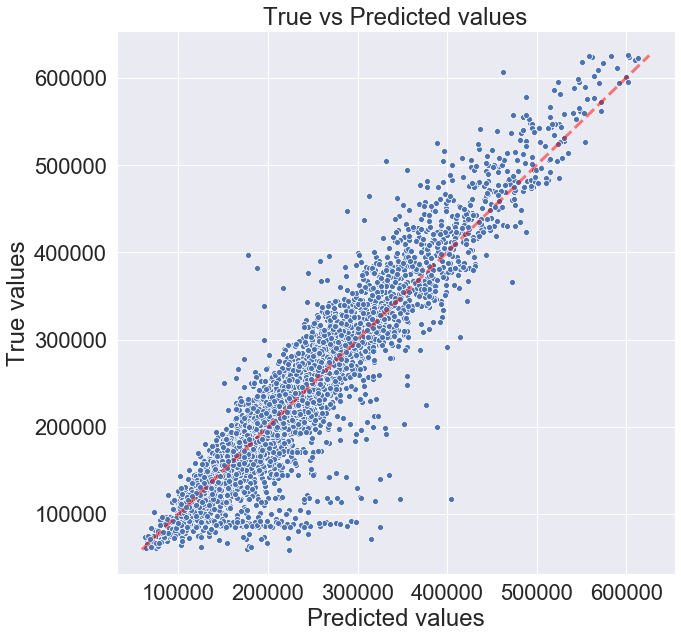

In [176]:
y_train_preds_est = gs.best_estimator_.predict(X_train)
evaluate_preds(y_train, y_train_preds_est)

R2:	0.883


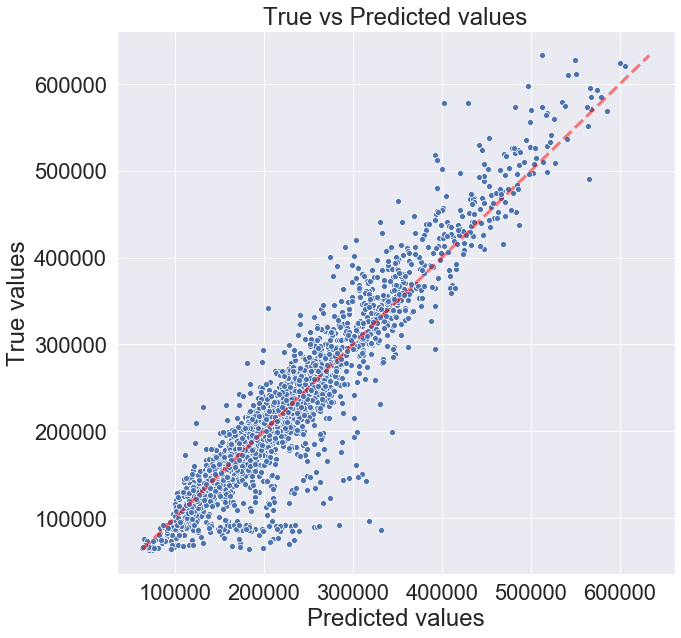

In [177]:
y_test_preds_est = gs.best_estimator_.predict(X_test)
evaluate_preds(y_test, y_test_preds_est)

In [178]:
x_test.head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,...,ratio_square_and_mean_square_by_rooms,bigger_then_mean,DistrictSize,IsDistrictLarge,MedPriceByDistrict,infrastructure,Mean_Infra_by_distr,diff_infra_and_mean_infra_by_distr,ratio_infra_and_mean_infra_by_distr,bigger_then_mean_infra
9997,725,58,0.138383,-0.339275,-0.291273,0.055720,-0.281584,0.168932,1972.0,1.600102,...,-0.558183,0,-0.219572,1,-0.593454,-3.506060,-1.419643,-2.086417,1.469677,0
9998,15856,74,0.138383,0.670598,1.016596,-1.235820,-1.267784,-1.863471,1977.0,-0.363696,...,0.958548,1,-0.459444,1,0.424421,-3.616747,-2.413912,-1.202835,0.498293,0
9999,5480,190,-1.112569,-2.107513,-1.962410,1.605567,-1.070544,-1.238116,1909.0,-0.998513,...,-2.739609,0,-0.878587,0,NaN,6.782527,6.782527,0.000000,0.000000,0
10000,15664,47,0.138383,0.867743,0.757735,0.830643,2.874258,1.419641,2007.0,-0.145102,...,1.254641,1,-0.532668,1,0.146602,0.360050,0.884053,-0.524003,-0.592728,0
10001,14275,27,-1.112569,-0.462016,0.272949,-1.235820,1.888058,0.637948,2017.0,-0.394031,...,0.670917,1,2.234691,1,-1.240895,-4.547320,-3.788738,-0.758581,0.200220,0


In [179]:
x_test["MedPriceByDistrict"].isnull().sum()

61

In [180]:
x_test.loc[x_test["MedPriceByDistrict"].isnull(), 'MedPriceByDistrict'] = data['MedPriceByDistrict'].median()

In [181]:
feature_names = ['Rooms', 'Square', 'LifeSquare', 'KitchenSquare', 'Floor', 'HouseFloor',
                'Ecology_1', "['Eco2_Eco3']_AB", "['Eco2_Eco3']_BA", "['Eco2_Eco3']_BB", 'Social_1', 'Social_2', 'Social_3', 
                 'Healthcare_1', 'Helthcare_2', 'Shops_1', 'Shops_2_bin']

new_feature_names = ['HouseAge', 'Mean_Square_by_rooms',
 'diff_square_and_mean_square_by_rooms', 'ratio_square_and_mean_square_by_rooms', 'bigger_then_mean', 
                     'DistrictSize', 'IsDistrictLarge', 'MedPriceByDistrict', 'ratio_infra_and_mean_infra_by_distr', 'bigger_then_mean_infra']

In [182]:
x_valid = x_test[feature_names + new_feature_names]

In [183]:
x_valid

,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,Ecology_1,['Eco2_Eco3']_AB,['Eco2_Eco3']_BA,['Eco2_Eco3']_BB,...,HouseAge,Mean_Square_by_rooms,diff_square_and_mean_square_by_rooms,ratio_square_and_mean_square_by_rooms,bigger_then_mean,DistrictSize,IsDistrictLarge,MedPriceByDistrict,ratio_infra_and_mean_infra_by_distr,bigger_then_mean_infra
9997,0.138383,-0.339275,-0.291273,0.055720,-0.281584,0.168932,1.600102,0,0,1,...,0.688118,0.043364,-0.558638,-0.558183,0,-0.219572,1,-0.593454,1.469677e+00,0
9998,0.138383,0.670598,1.016596,-1.235820,-1.267784,-1.863471,-0.363696,0,0,1,...,0.417315,0.043364,0.959331,0.958548,1,-0.459444,1,0.424421,4.982928e-01,0
9999,-1.112569,-2.107513,-1.962410,1.605567,-1.070544,-1.238116,-0.998513,0,0,1,...,4.100233,-1.052401,-1.986830,-2.739609,0,-0.878587,0,-0.210664,0.000000e+00,0
10000,0.138383,0.867743,0.757735,0.830643,2.874258,1.419641,-0.145102,0,0,1,...,-1.207502,0.043364,1.255665,1.254641,1,-0.532668,1,0.146602,-5.927277e-01,0
10001,-1.112569,-0.462016,0.272949,-1.235820,1.888058,0.637948,-0.394031,0,0,1,...,-1.749108,-1.052401,0.486565,0.670917,1,2.234691,1,-1.240895,2.002200e-01,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14992,1.389335,0.559647,0.693629,0.055720,-0.478824,-0.612762,-0.997092,0,0,1,...,0.633957,1.443676,-0.778913,-0.575692,0,-0.461969,1,0.480741,-3.185346e+00,0
14993,-1.112569,-0.843893,-0.950200,1.088951,0.901857,0.637948,-0.938848,0,0,1,...,-1.749108,-1.052401,-0.087446,-0.120578,0,1.613550,1,-0.861524,9.641973e-02,0
14994,1.389335,1.117628,0.550393,0.830643,1.493577,1.419641,-0.237867,0,0,1,...,-0.232612,1.443676,0.059805,0.044202,1,-0.648816,0,1.388148,1.554312e-15,1
14995,0.138383,1.298079,1.699120,-1.235820,-0.676064,-0.143746,-0.394031,0,0,1,...,0.417315,0.043364,1.902516,1.900964,1,0.030399,1,-0.428837,2.523619e-01,0


In [184]:
price_predicted = gs.best_estimator_.predict(x_valid)
price_predicted

array([159881.37065304, 235425.39398106, 159733.97263638, ...,
       318289.51572588, 186482.16013561, 178560.63840255])

In [185]:
len(price_predicted)

5000

In [186]:
ids = np.array(x_test['Id'])
ids

array(['725', '15856', '5480', ..., '5783', '4780', '12504'], dtype=object)

In [187]:
results = pd.DataFrame({'Id': ids, 'Price': price_predicted}, columns=['Id', 'Price'])
results

,Id,Price
0,725,159881.370653
1,15856,235425.393981
2,5480,159733.972636
3,15664,356630.309547
4,14275,147529.220446
...,...,...
4995,8180,237748.957833
4996,4695,135948.386221
4997,5783,318289.515726
4998,4780,186482.160136


### Сохранение предсказания

In [188]:
RESULTS_FILE_PATH = 'LSbitneva_predictions.csv'
results.to_csv(RESULTS_FILE_PATH, index=False)